In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.pylabtools import figsize


sns.set(font_scale=2)
figsize(20, 20)

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 50)

In [2]:
figsize(20, 20)

# Exploratory Data Analysis and Preprocessing

**We start by analyzing the data at hand**

In [10]:
telco_df = pd.read_csv('./datasets/telco.csv')

telco_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

**The dataset is really small. This can impose some though choices when it comes to outliers and feature engineering.**

**Throwing out outliers is very hard in this case as the information value of each row is high with such low row numbers.**

**If we engineer too many features the column/row ration will get very big, resulting in overfitting**


In [6]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7000,151.65,Yes


## Data Quality checks

**Checking the datatypes. It seems retire field should be an int, as it is a flag.**

In [7]:
telco_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
telco_df['retire'].unique()

KeyError: 'retire'

In [ ]:
telco_df['retire'] = telco_df['retire'].astype('int64')

**Checking for missing values. Seems all is good. Since there are no string based fields we don't have to check for question marks or empty strings in rows.**

In [ ]:
sns.heatmap(telco_df.isnull(), cbar = False, cmap = 'viridis')

**Checking correlation matrix to see if we have any redundant columns.**

**We don't exactly have columns that are 1:1 correlated to another. However longmon and equipmon are very highly correlated, they are not exactly identical. They might come in use at feature engineering stage so I keep them.**

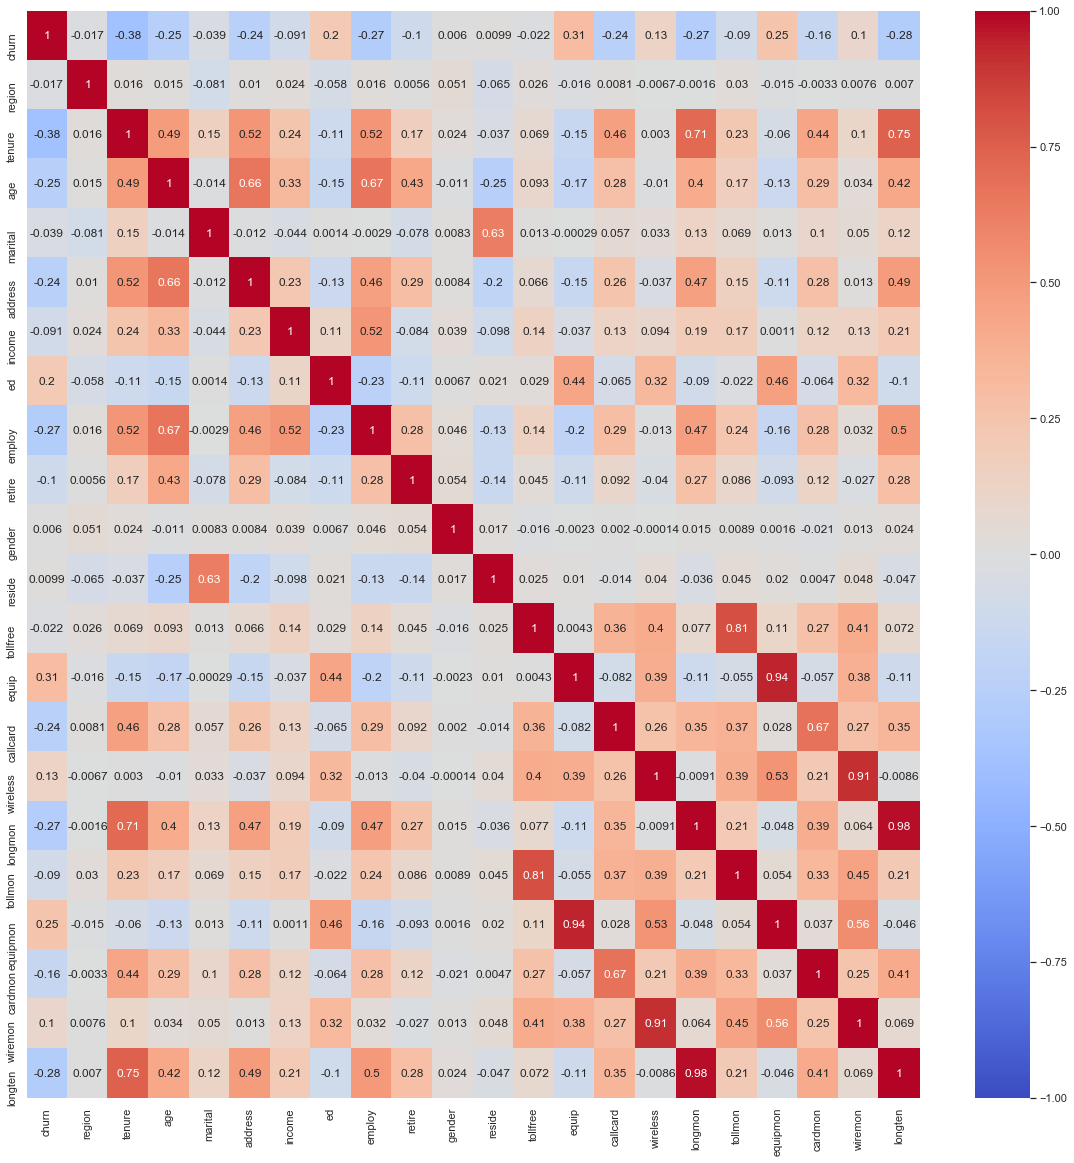

In [ ]:
sns.set(font_scale=1)
sns.heatmap(telco_df[telco_df.columns[:21].insert(0,'churn')].corr(), annot=True, cmap='coolwarm', vmin=-1)

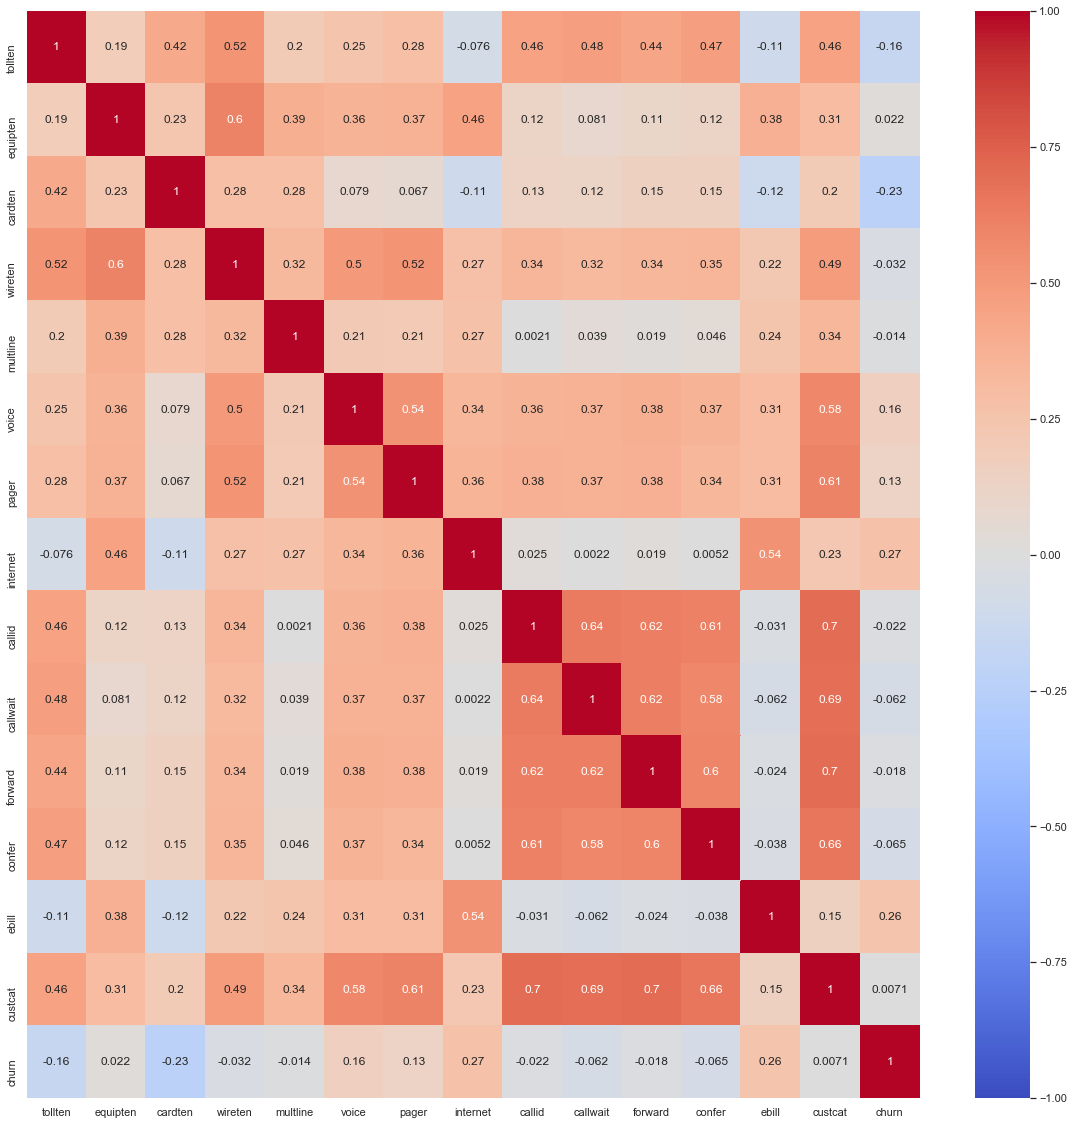

In [ ]:
sns.heatmap(telco_df[telco_df.columns[21:]].corr(), annot=True, cmap='coolwarm', vmin=-1)

**As we can see the dataset is imbalanced towards no churn. We will have to keep this in mind to avoid our models overfitting on the imbalance.**

In [11]:
telco_df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## Feature Engineering

**Let's see the distributions of the columns to get some ideas.**

In [ ]:
f, axes_array = plt.subplots(len(telco_df.columns), figsize=(15,15 * len(telco_df.columns)))

for i, column in enumerate(telco_df.columns.drop('Churn')):
    g = sns.FacetGrid(telco_df, hue="Churn", )

    g = g.map(sns.distplot, column, rug=True, ax=axes_array[i])

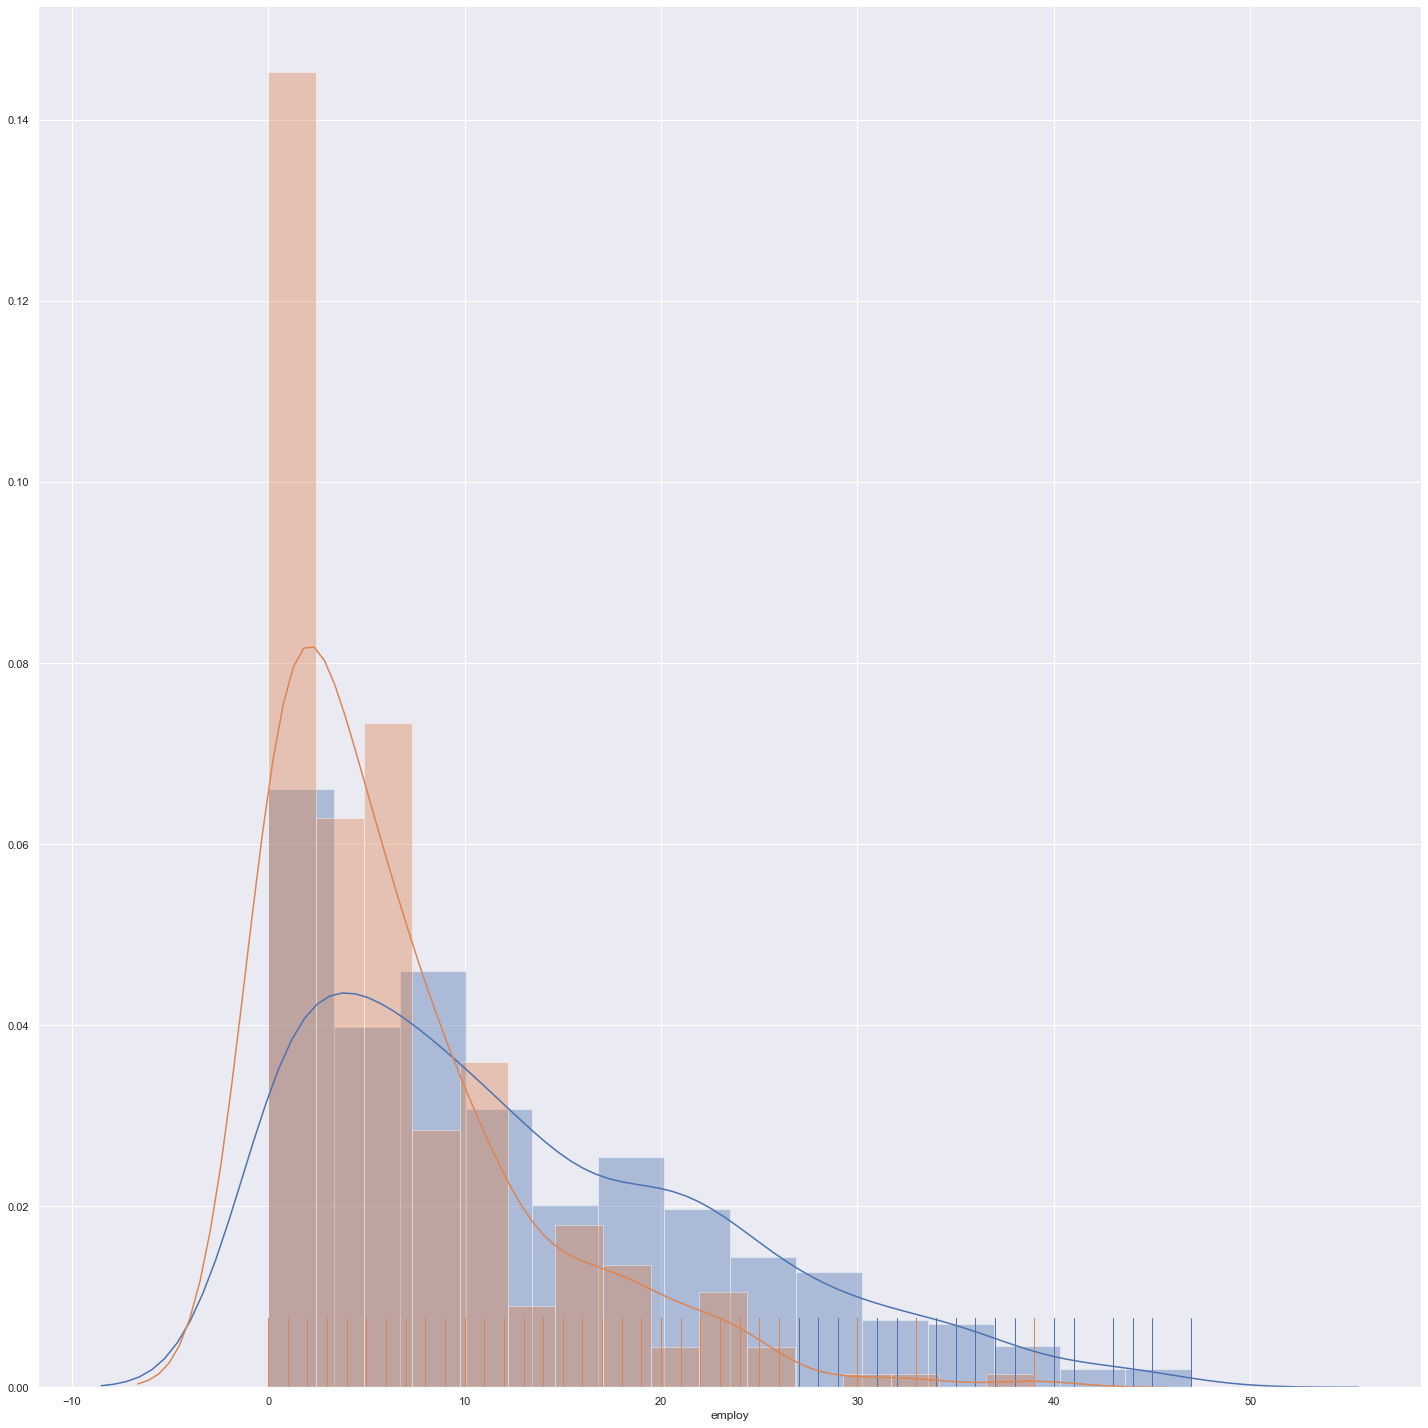

In [ ]:
telco_df['employ'].value_counts()[0]
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'employ', rug=True)

**Does this mean these customers are unemployed, or that they have just switched employer?**

**Let's see if we can find different patterns in churn for them.**

In [ ]:
def is_not_zero(value):
    if value > 0:
        return 1
    return 0

telco_df['is_employed'] = telco_df['employ'].apply(is_not_zero)
telco_df[['is_employed', 'churn']].groupby('is_employed').mean()

,churn
is_employed,
0,0.4057
1,0.2584


**It seems it is worth keeping this field as this flag (whether our employment assumption is true or not) seems to highly correlate with churn**

In [ ]:
print(telco_df['tollmon'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'tollmon', rug=True)

**_tollmon_ shows a normal distribution except for the many zeros. Might worth adding a flag for this.**

In [ ]:
telco_df['has_tollfree'] = telco_df['tollmon'].apply(is_not_zero)
telco_df[['has_tollfree', 'churn']].groupby('has_tollfree').mean()

,churn
has_tollfree,
0,0.2838
1,0.2632


**It seems this field doesn't mean much of a difference in churn regards, we drop this field**

In [ ]:
telco_df = telco_df.drop('has_tollfree', axis=1)

**We will do the same checks for _equipmon_, _cardmon_, _wiremon_, _tollten_, _equipten_, _cardten_, _wireten_**

614


,churn
has_equipment,
0,0.1661
1,0.4456


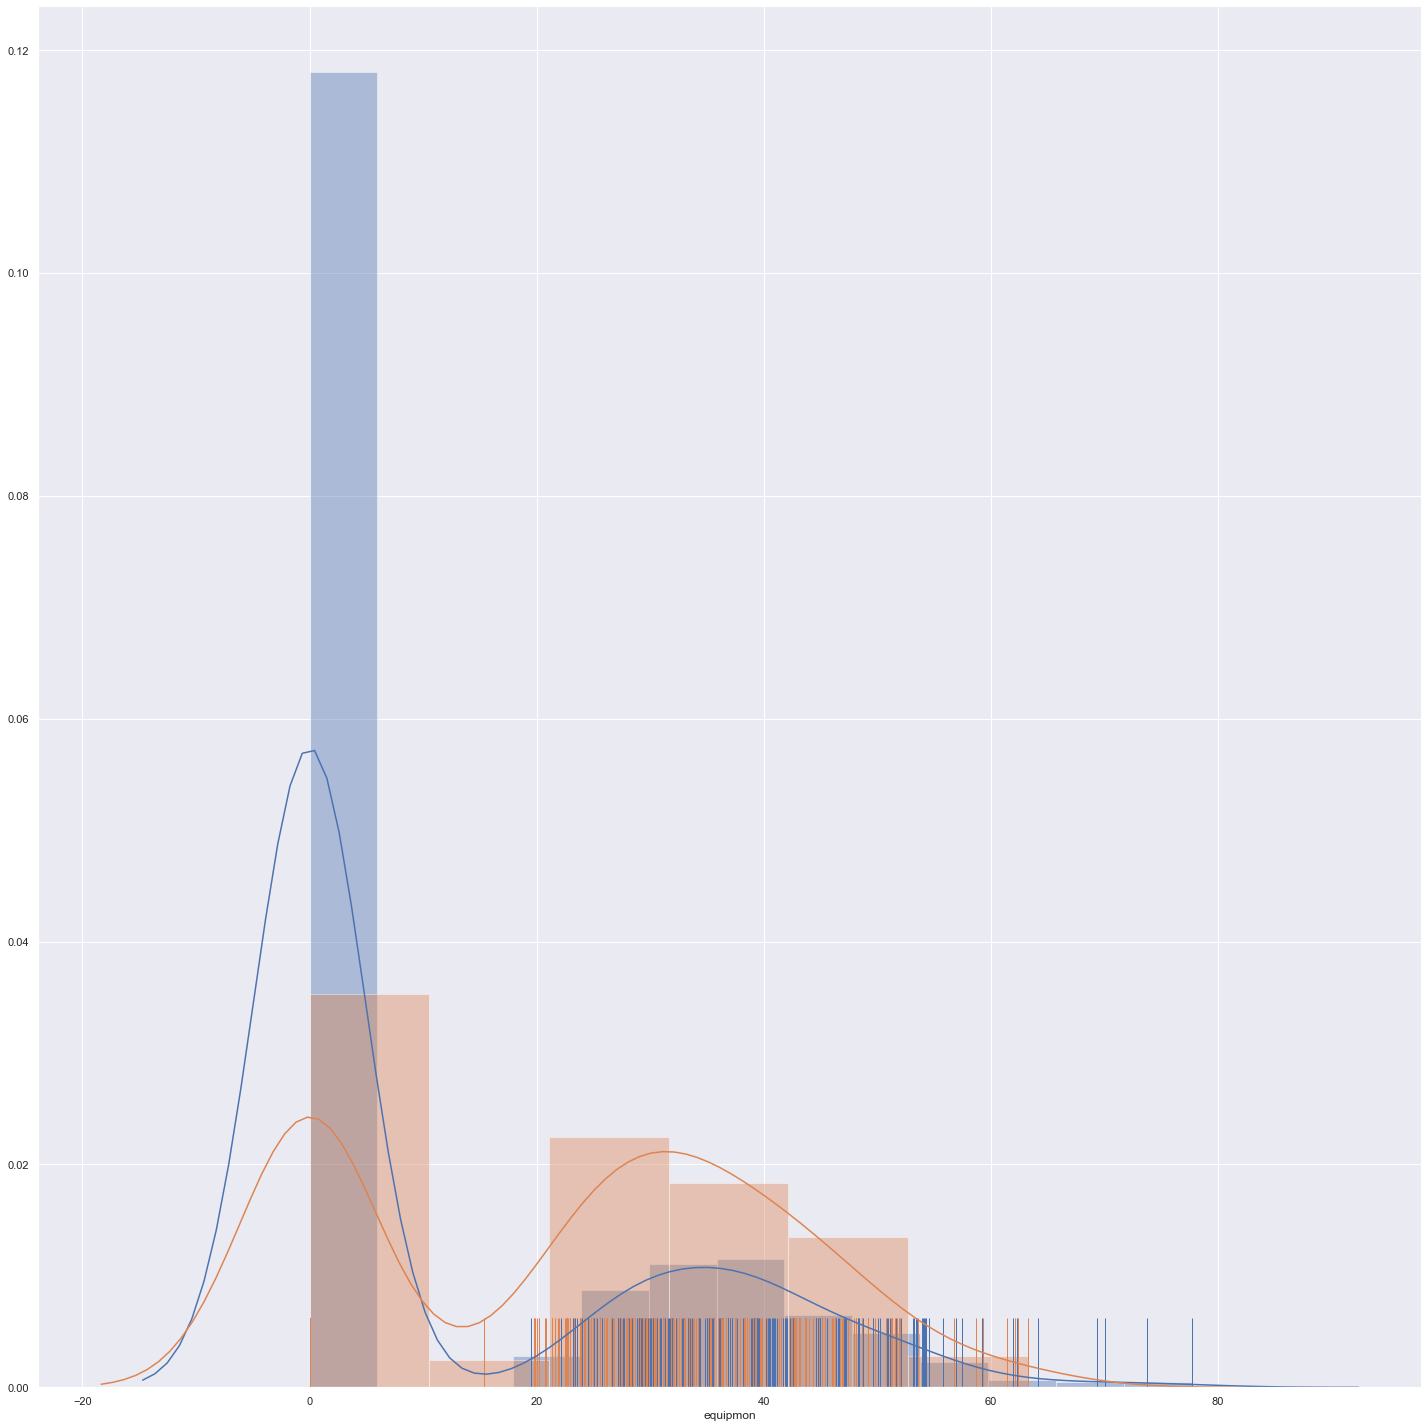

In [ ]:
print(telco_df['equipmon'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'equipmon', rug=True)
telco_df['has_equipment'] = telco_df['equipmon'].apply(is_not_zero)
telco_df[['has_equipment', 'churn']].groupby('has_equipment').mean()

322


,churn
has_card,
0,0.4317
1,0.1991


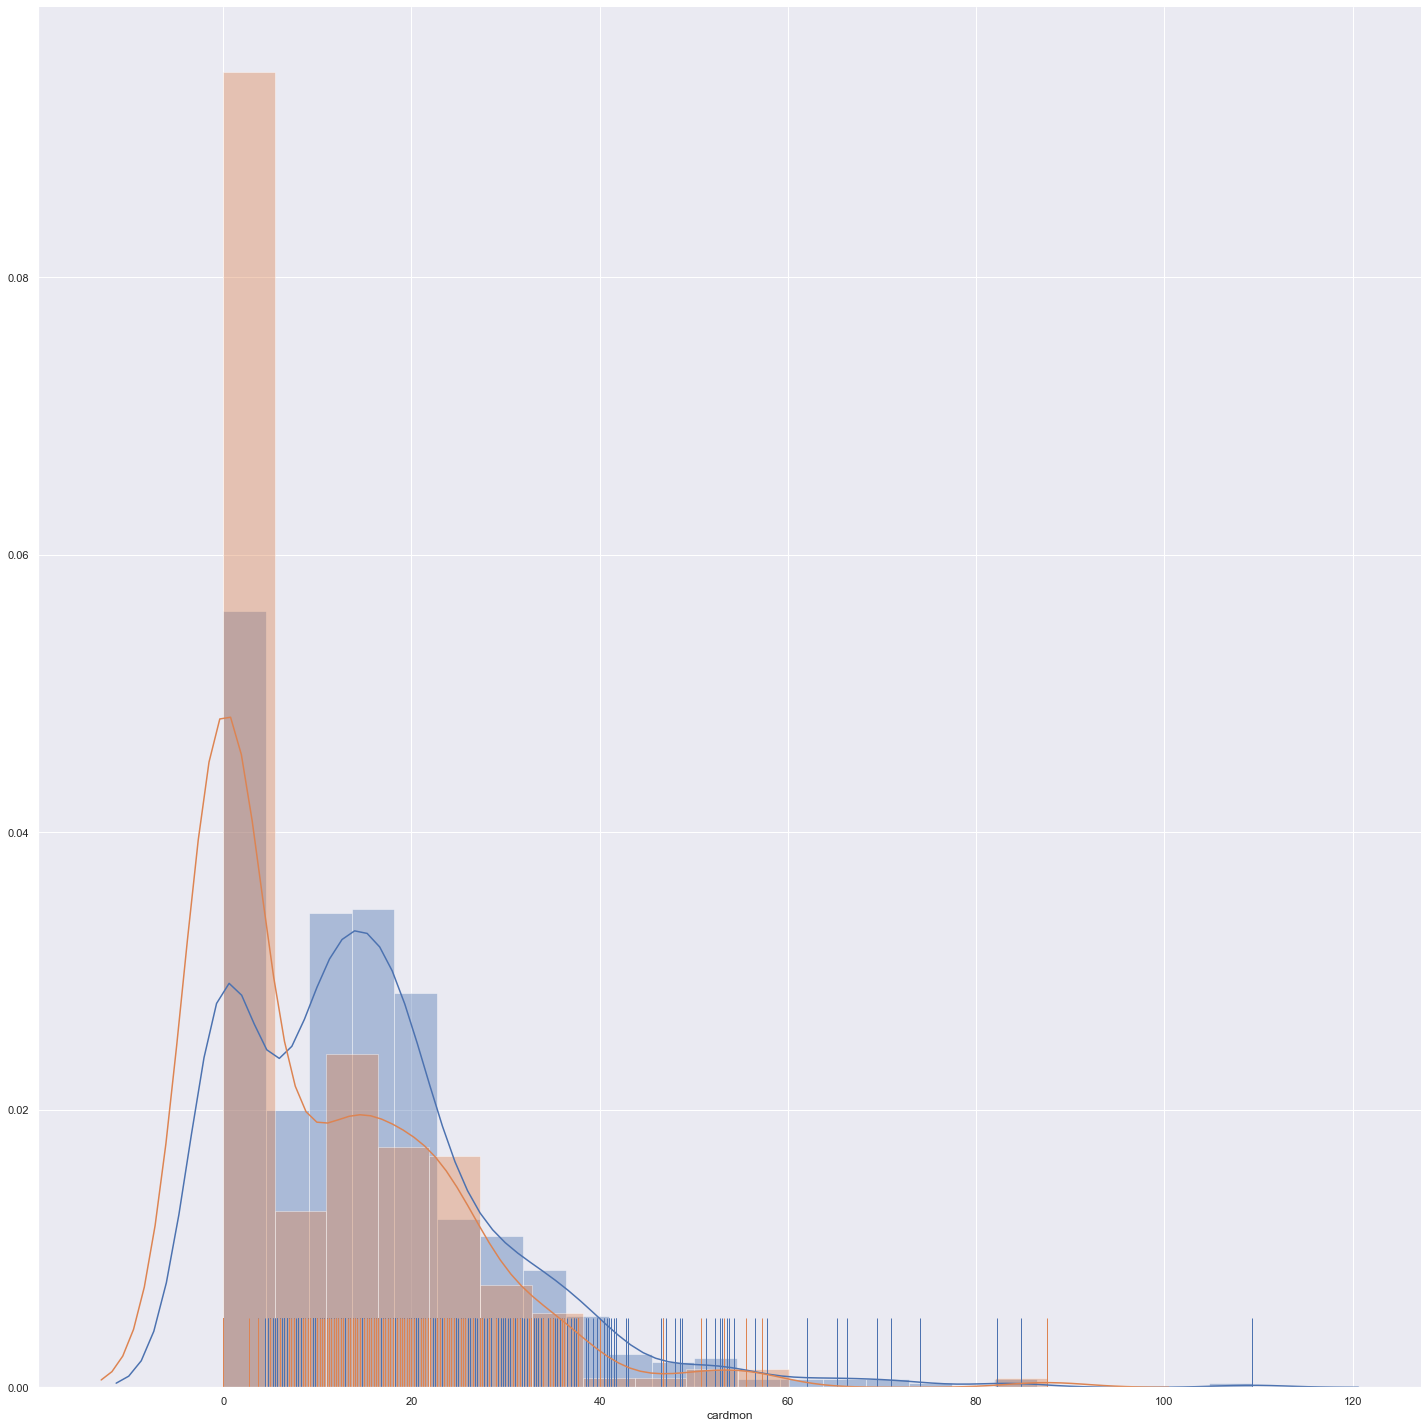

In [ ]:
print(telco_df['cardmon'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'cardmon', rug=True)
telco_df['has_card'] = telco_df['cardmon'].apply(is_not_zero)
telco_df[['has_card', 'churn']].groupby('has_card').mean()

704


,churn
has_wireless,
0,0.2358
1,0.3649


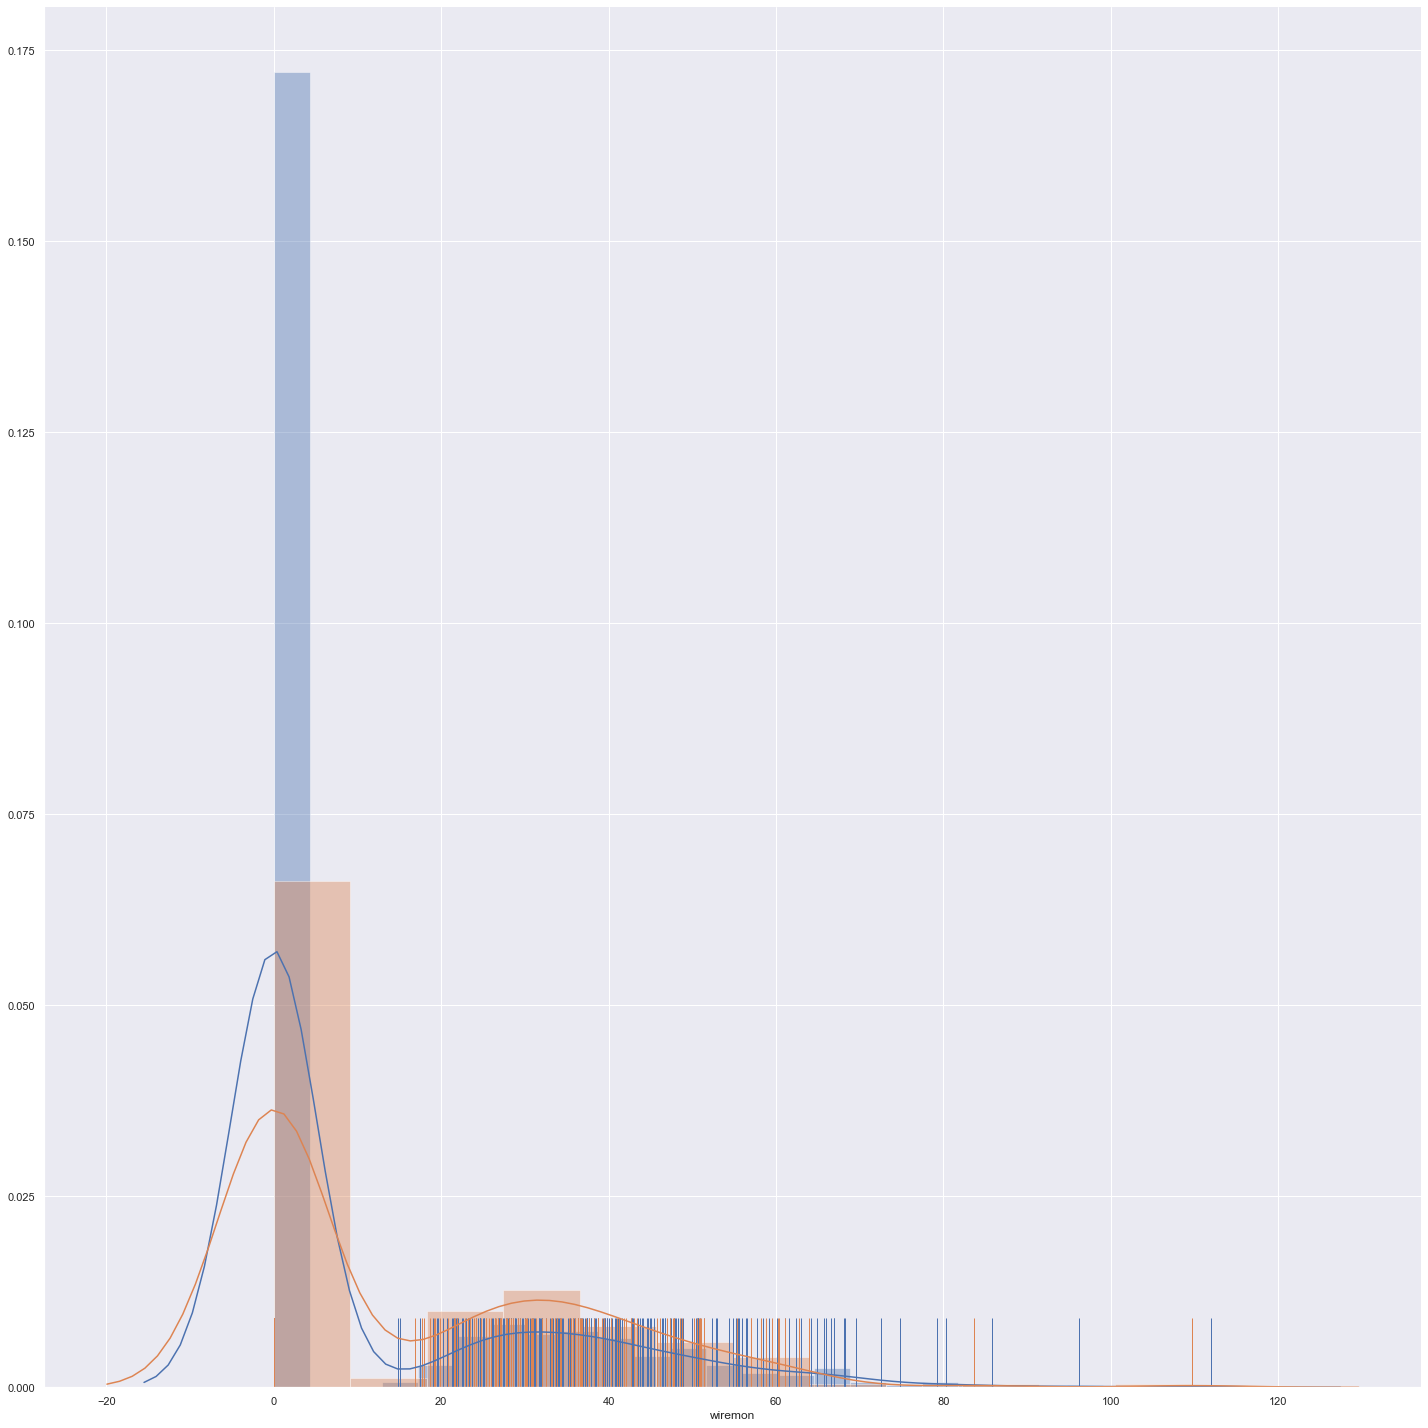

In [ ]:
print(telco_df['wiremon'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'wiremon', rug=True)
telco_df['has_wireless'] = telco_df['wiremon'].apply(is_not_zero)
telco_df[['has_wireless', 'churn']].groupby('has_wireless').mean()

526


,churn
has_tollten,
0,0.2833
1,0.2637


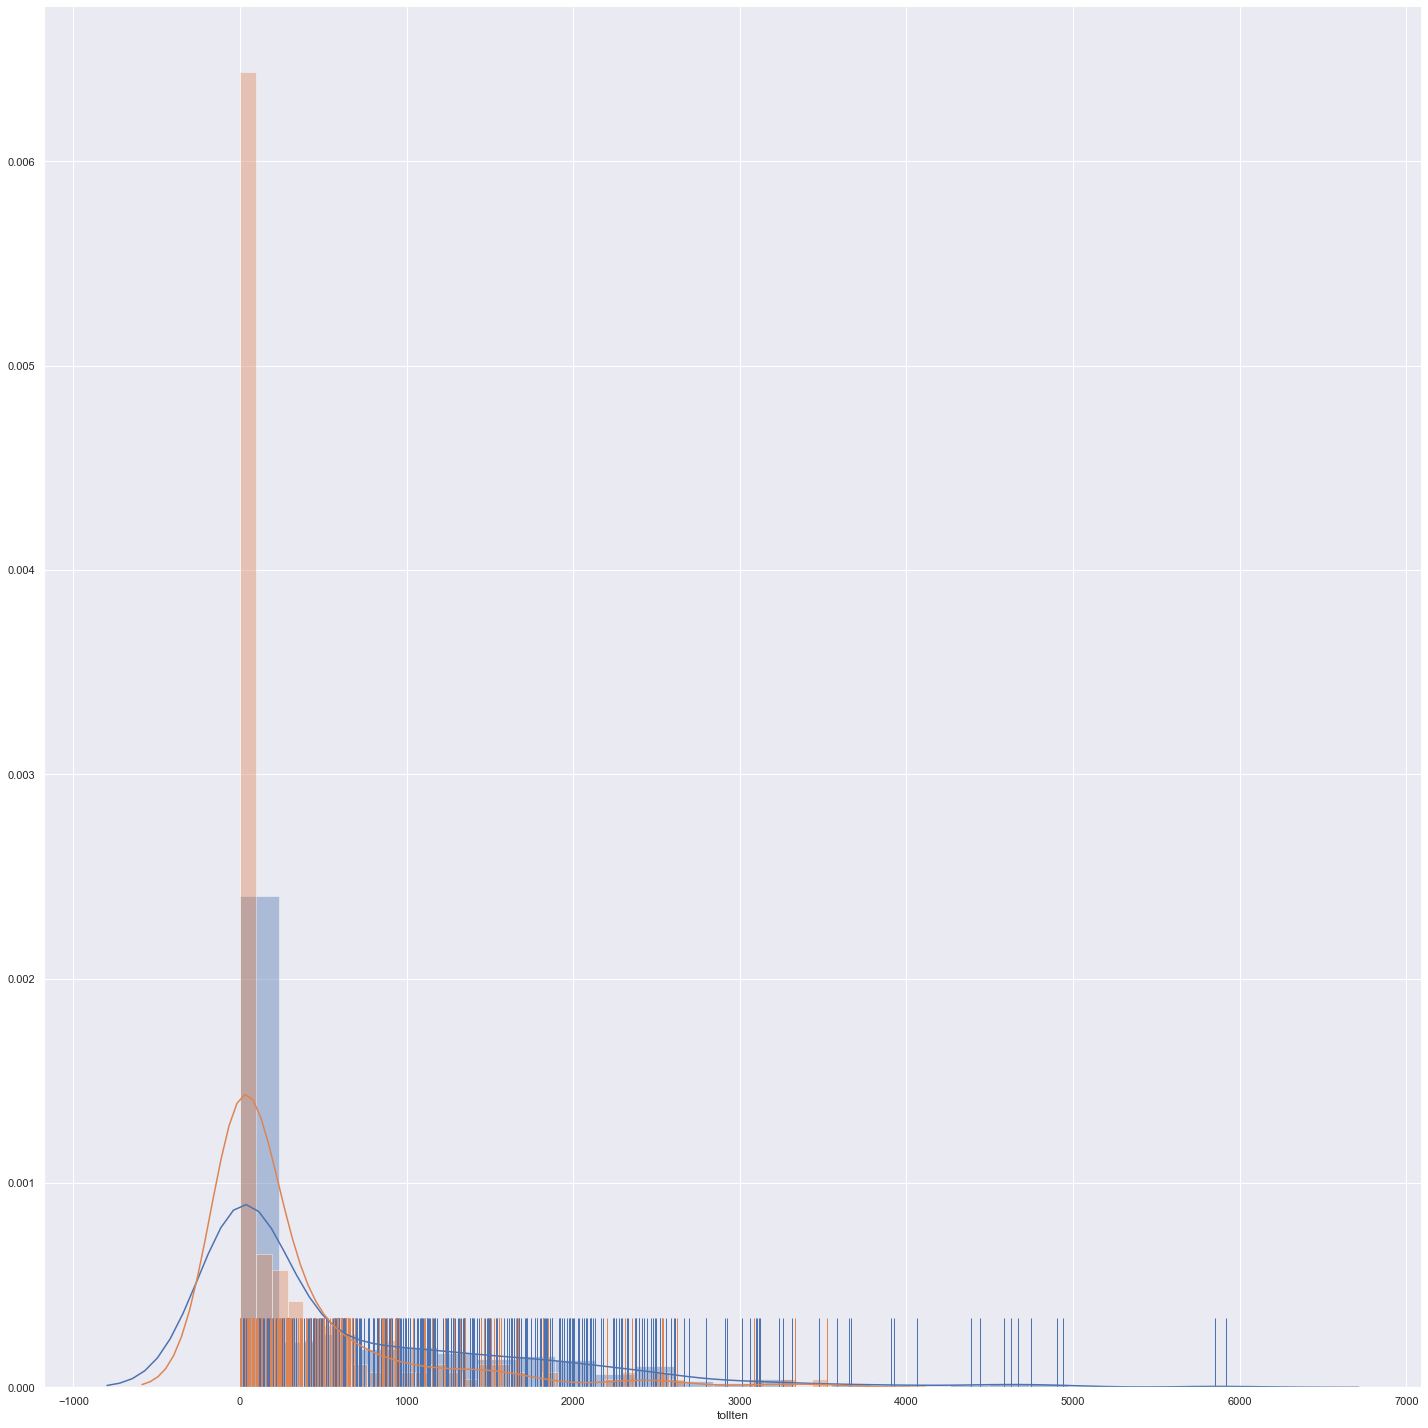

In [ ]:
print(telco_df['tollten'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'tollten', rug=True)
telco_df['has_tollten'] = telco_df['tollten'].apply(is_not_zero)
telco_df[['has_tollten', 'churn']].groupby('has_tollten').mean()

614


,churn
has_equipten,
0,0.1661
1,0.4456


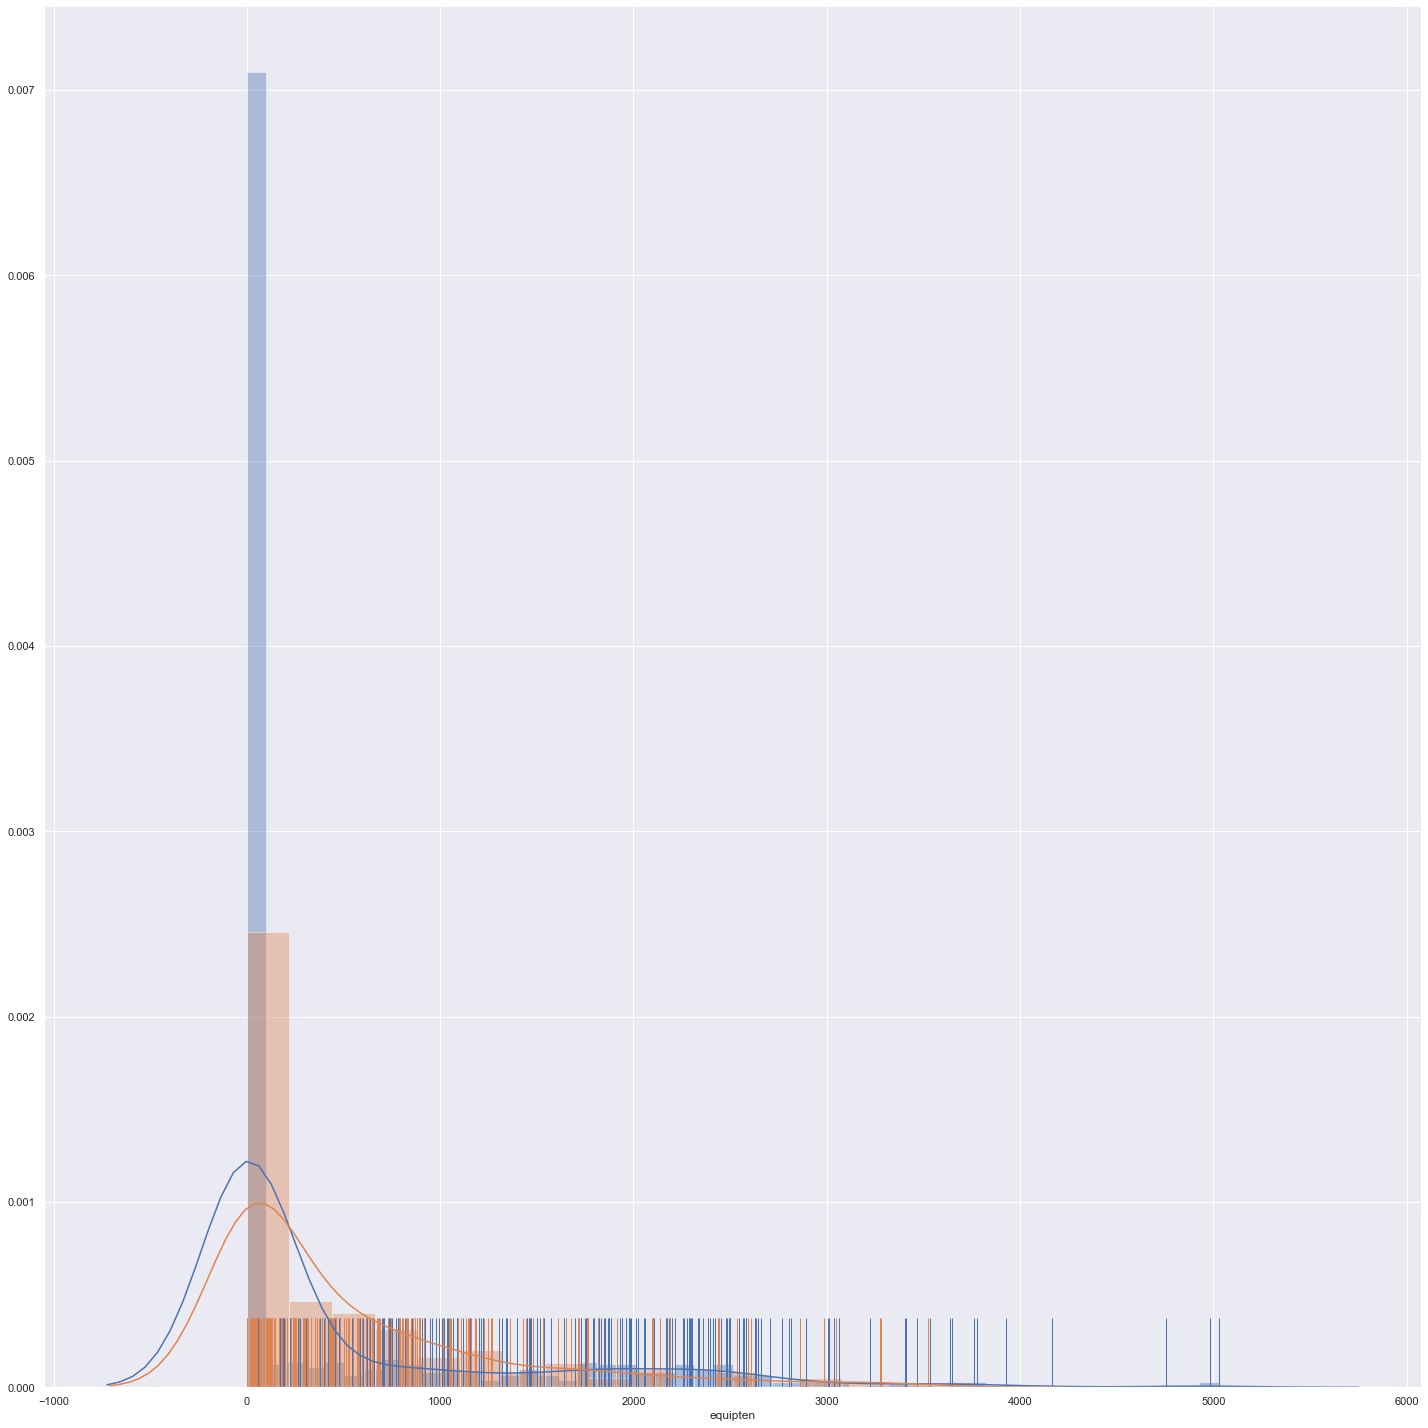

In [ ]:
telco_df = telco_df.drop('has_tollten', axis=1)
print(telco_df['equipten'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'equipten', rug=True)
telco_df['has_equipten'] = telco_df['equipten'].apply(is_not_zero)
telco_df[['has_equipten', 'churn']].groupby('has_equipten').mean()

322


,churn
has_cardten,
0,0.4317
1,0.1991


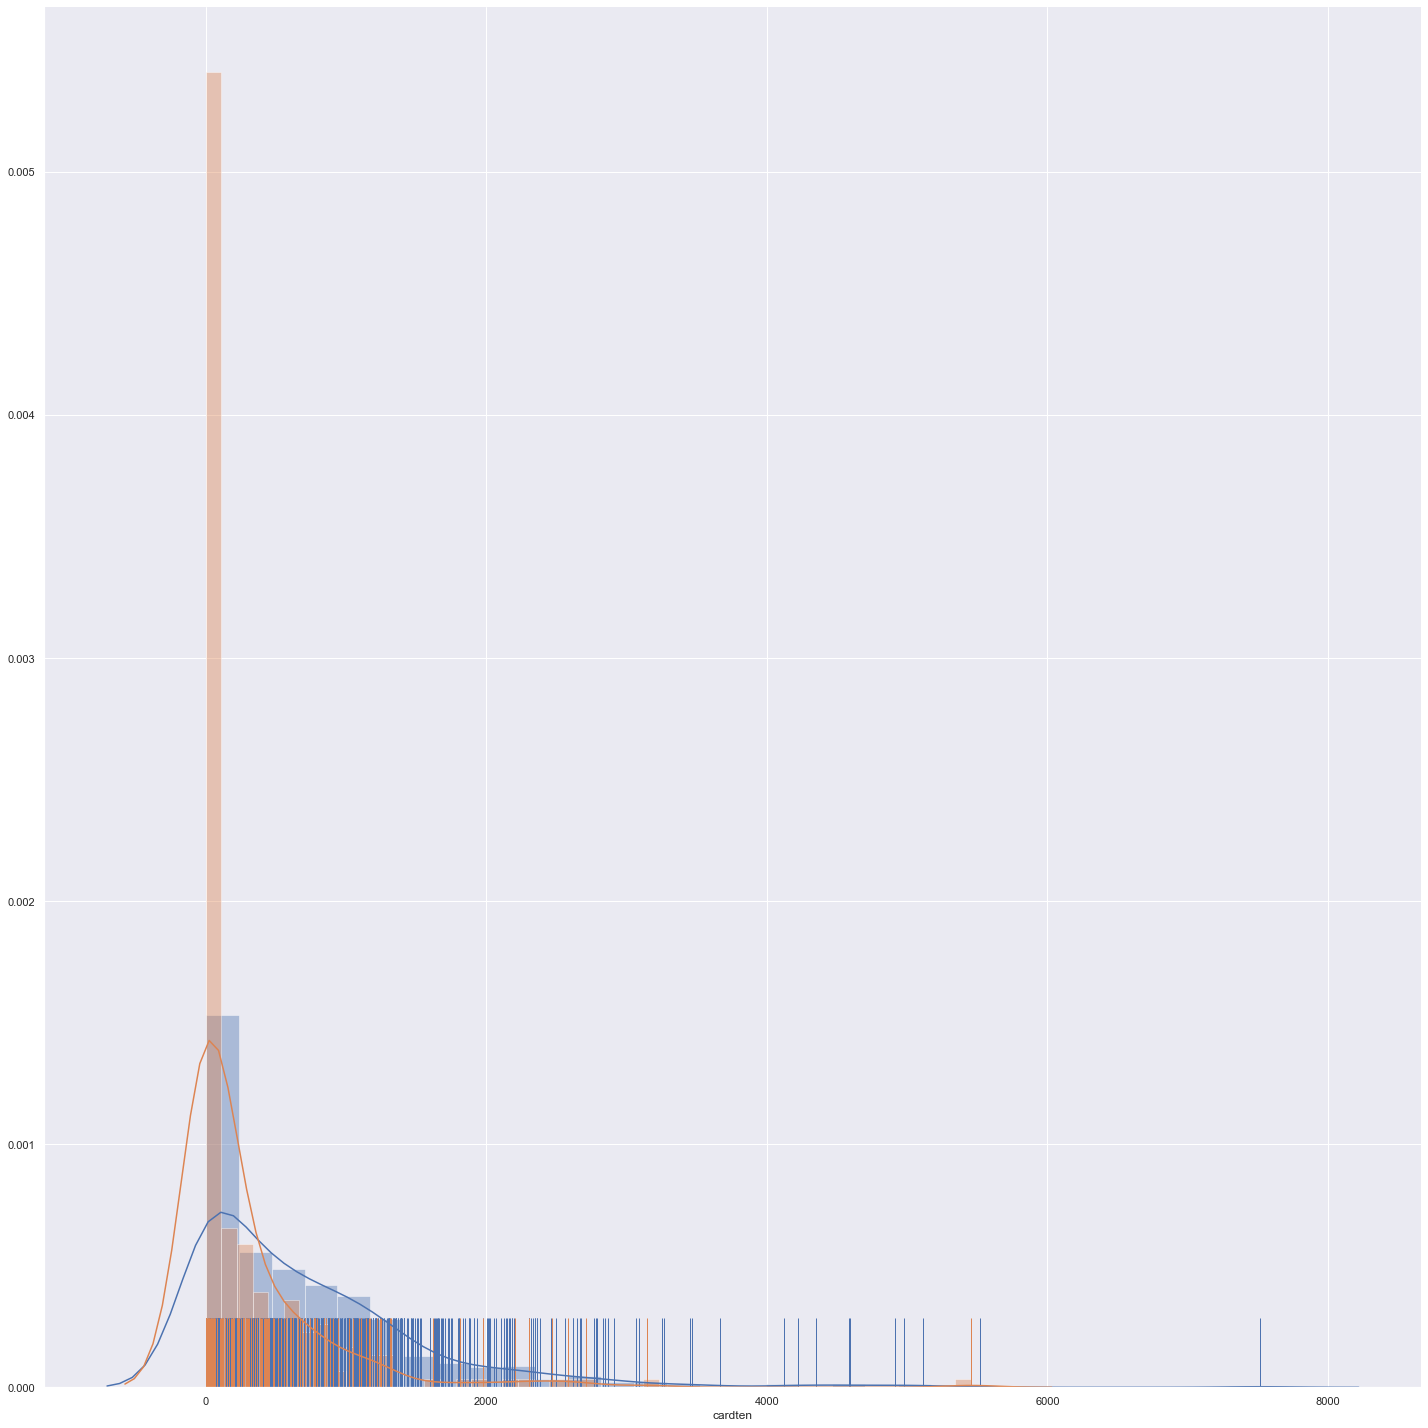

In [ ]:
print(telco_df['cardten'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'cardten', rug=True)
telco_df['has_cardten'] = telco_df['cardten'].apply(is_not_zero)
telco_df[['has_cardten', 'churn']].groupby('has_cardten').mean()

704


,churn
has_wireten,
0,0.2358
1,0.3649


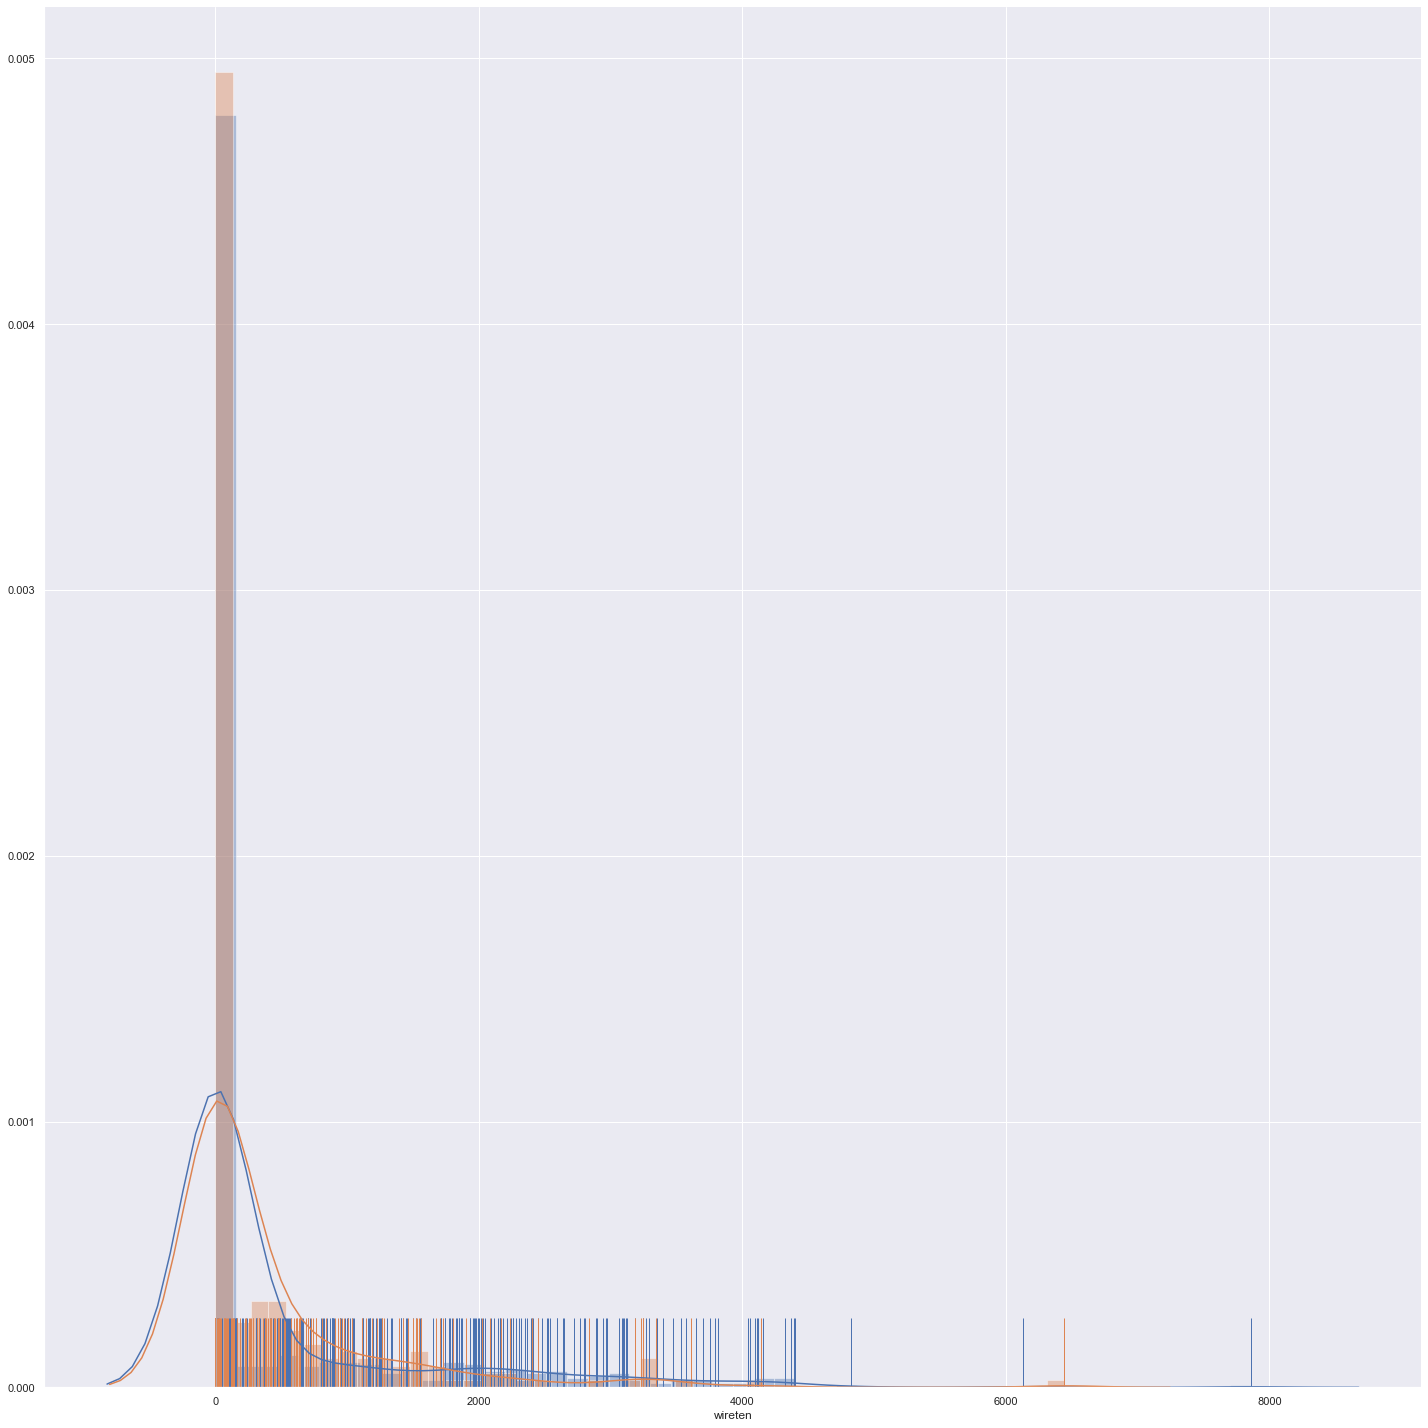

In [ ]:
print(telco_df['wireten'].value_counts()[0])
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'wireten', rug=True)
telco_df['has_wireten'] = telco_df['wireten'].apply(is_not_zero)
telco_df[['has_wireten', 'churn']].groupby('has_wireten').mean()

**Let's check if the newly introduced fields are redundant.**

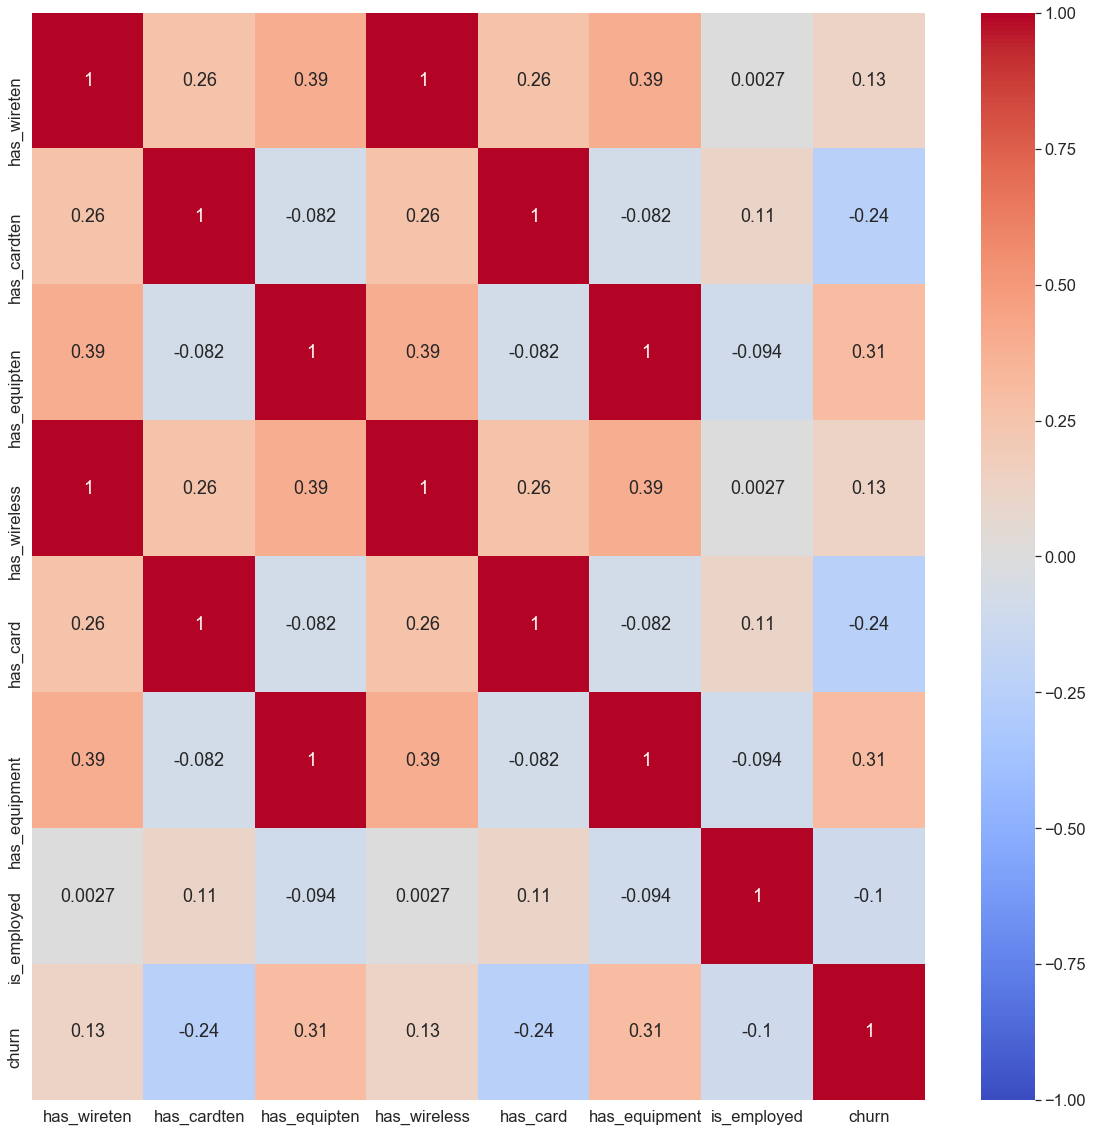

In [ ]:
sns.set(font_scale=1.5)

df_new_fields = telco_df[['has_wireten', 'has_cardten', 'has_equipten', 'has_wireless', 'has_card', 'has_equipment', 'is_employed', 'churn']]
sns.heatmap(df_new_fields.corr(), annot=True, cmap='coolwarm', vmin=-1)

**It seems the fields we derived from over tenure usage and basic usage contain the same information, so we can drop one of them.**

In [ ]:
telco_df = telco_df.drop(['has_wireten', 'has_cardten', 'has_equipten'], axis=1)

### Binning

**Sometimes it is worth doing binning of interval data to make it more simple and understandable for man and machine alike**

**Looking at the data we see 2 potential columns for binning: tenure and age**

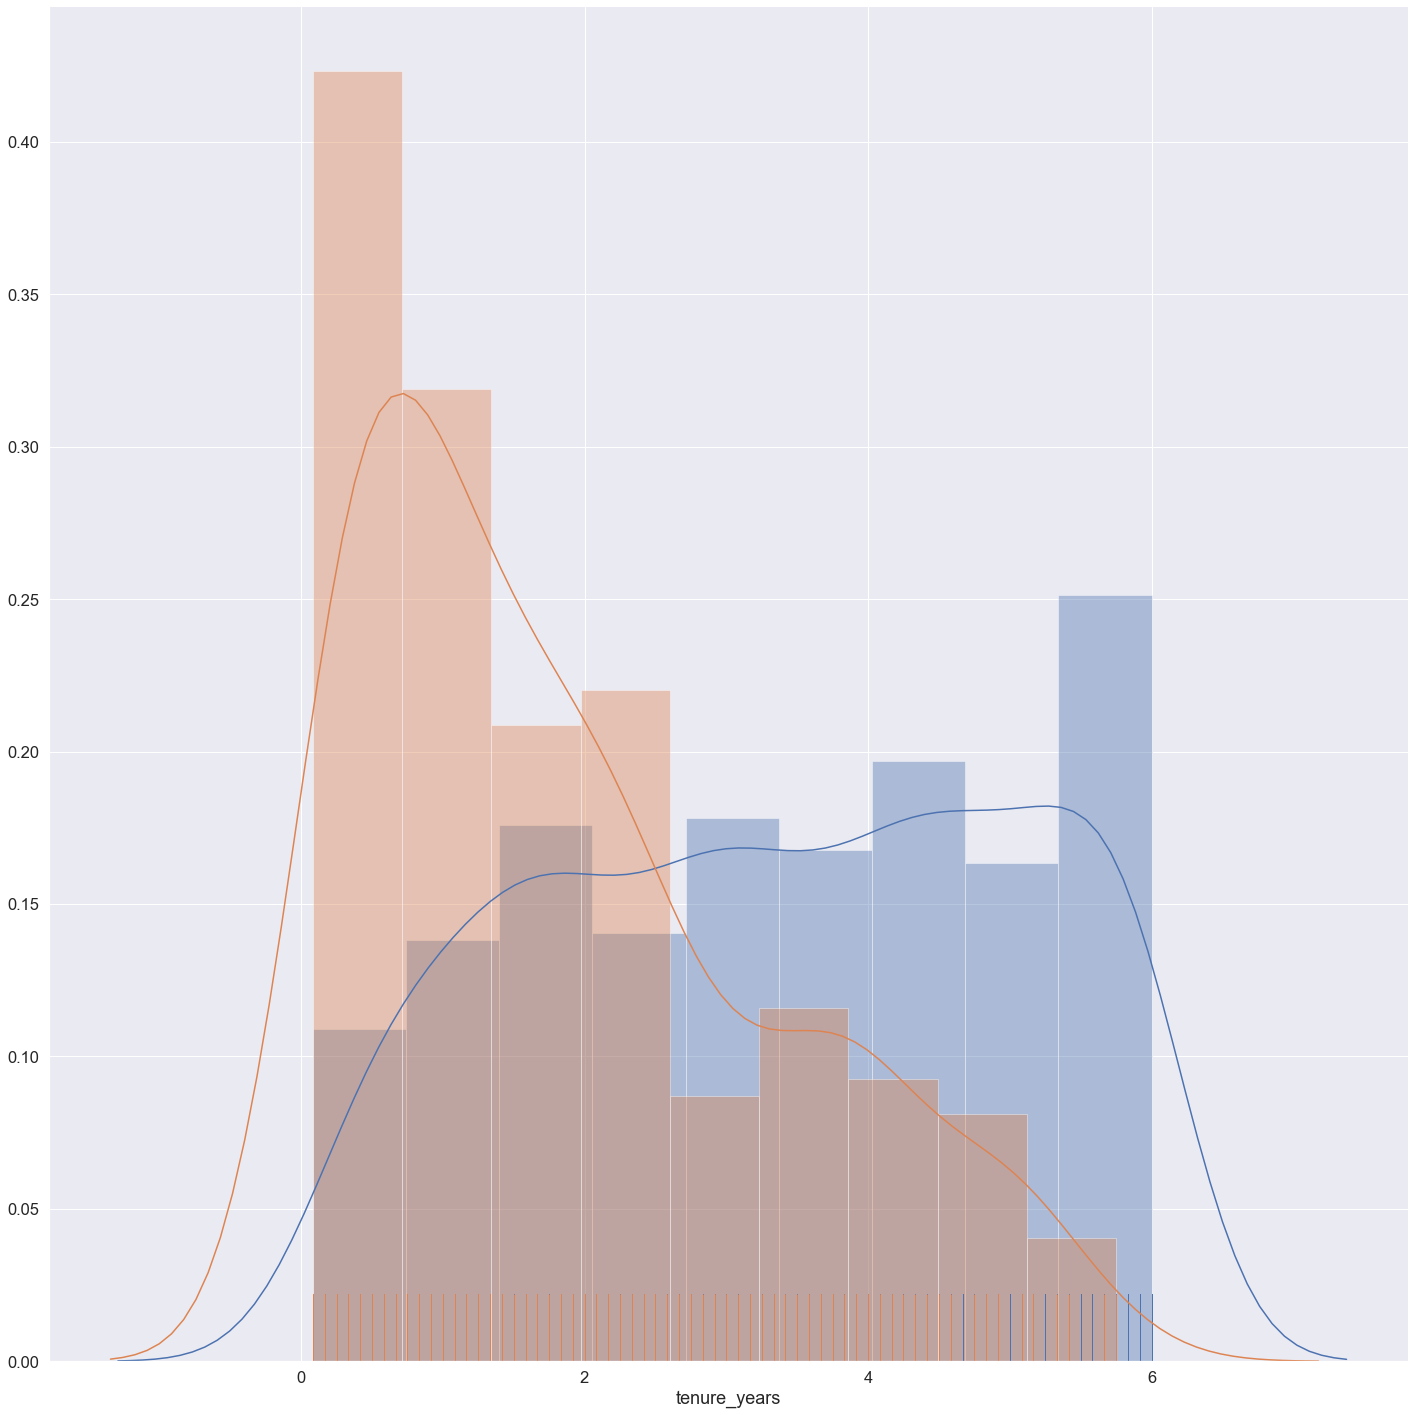

In [ ]:
telco_df['tenure_years'] = telco_df['tenure'] / 12
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'tenure_years', rug=True)

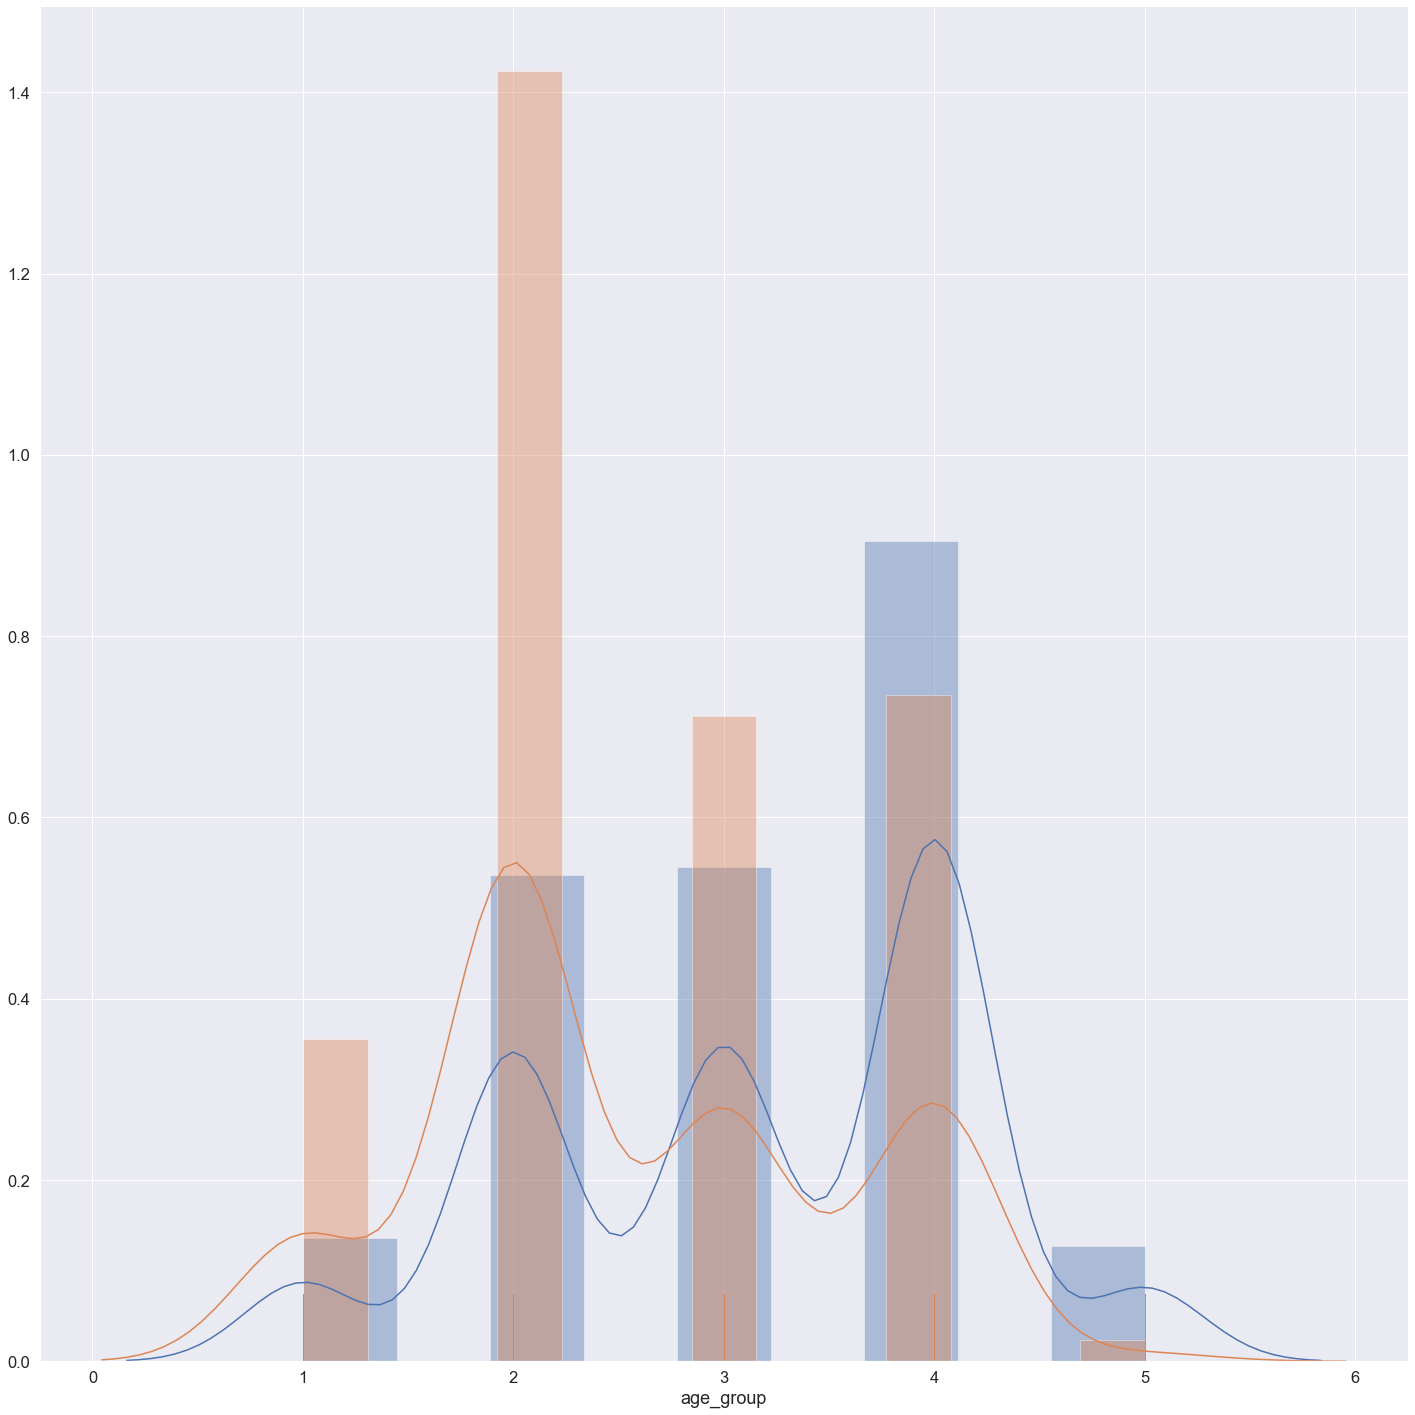

In [ ]:
def age_binner(age):
    if age < 25:
        return 1
    if age < 36:
        return 2
    if age < 45:
        return 3
    if age < 65:
        return 4
    return 5

telco_df['age_group'] = telco_df['age'].apply(age_binner)
g = sns.FacetGrid(telco_df, hue='churn', height=20)
g = g.map(sns.distplot, 'age_group', rug=True)

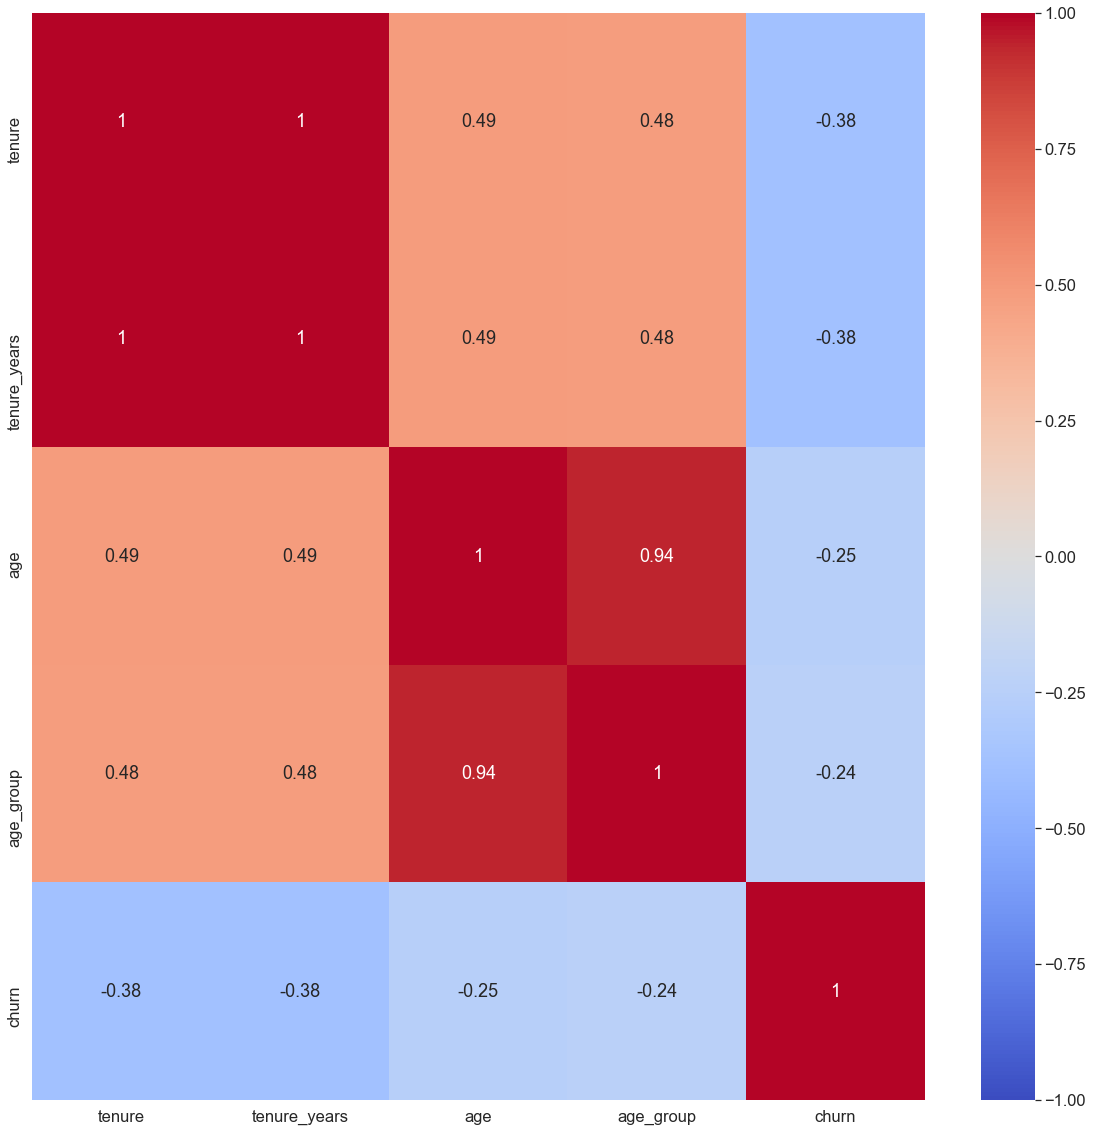

In [ ]:
df_new_fields = telco_df[['tenure', 'tenure_years', 'age', 'age_group', 'churn']]
sns.heatmap(df_new_fields.corr(), annot=True, cmap='coolwarm', vmin=-1)

**It seems binning didn't really help in this case, so we drop these columns**

In [ ]:
telco_df = telco_df.drop(['tenure_years', 'age_group'], axis=1)

### One-Hot encoding

Numerical nominal fields are to be seperated into indicator fields for each possible values. Leaving a numerical nominal field as it is is wrong, because some models are distance based and assume ordinality between the numbers.

In some cases this can work, for example a in field _settlement type_ we could assume ordinality between settlment types going from smaller to larger.

In the case of _region_ I assume there is no such ordinality, so I will use One-Hot Encoding for it.

In [ ]:
telco_df = telco_df.join(pd.get_dummies(telco_df['region'], prefix='region'), how='inner')
telco_df = telco_df.drop('region', axis=1)
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,reside,tollfree,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,equipten,cardten,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,custcat,churn,is_employed,has_equipment,has_card,has_wireless,region_1,region_2,region_3
0,13,44,1,9,64.0000,4,5,0,0,2,0,0,1,0,3.7000,0.0000,0.0000,7.5000,0.0000,37.4500,0.0000,0.0000,110.0000,0.0000,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,1,0
1,11,33,1,7,136.0000,5,5,0,0,6,1,0,1,1,4.4000,20.7500,0.0000,15.2500,35.7000,42.0000,211.4500,0.0000,125.0000,380.3500,0,1,1,0,1,1,1,1,0,4,1,1,0,1,1,0,0,1
2,68,52,1,24,116.0000,1,29,0,1,2,1,0,1,0,18.1500,18.0000,0.0000,30.2500,0.0000,1300.6000,1247.2000,0.0000,2150.0000,0.0000,0,0,0,0,1,1,0,1,0,3,0,1,0,1,0,0,0,1
3,33,33,0,12,33.0000,2,0,0,1,1,0,0,0,0,9.4500,0.0000,0.0000,0.0000,0.0000,288.8000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
4,23,30,1,9,30.0000,1,2,0,0,4,0,0,0,0,6.3000,0.0000,0.0000,0.0000,0.0000,157.0500,0.0000,0.0000,0.0000,0.0000,0,0,0,0,1,0,1,1,0,3,0,1,0,0,0,0,1,0


## Data Transformation

**We prepare the data for modeling now.**

**First off we have to handle outliers of our dataset. The problem with massive outliers is that some models (like regression) can be thrown off by them.**


**The easiest way to handle outliers is to throw the row off where we see an outlier in one of the columns. Now the problem is that our dataset is very small so we can't really afford to throw out any of them. Even if there is an outlier in one of the columns of a row, the rest of the columns contain valuable data. So what we will do instead is transform the outlier values and keep the row.**


**In such a low row count we can't be sure if an outlier really is an outstanding value or just and undersampled portion of the real data. This is why I will be very forgiving with outliers.**

[Text(0, 0, 'income'),
 Text(0, 0, 'longten'),
 Text(0, 0, 'tollten'),
 Text(0, 0, 'equipten'),
 Text(0, 0, 'cardten'),
 Text(0, 0, 'wireten')]

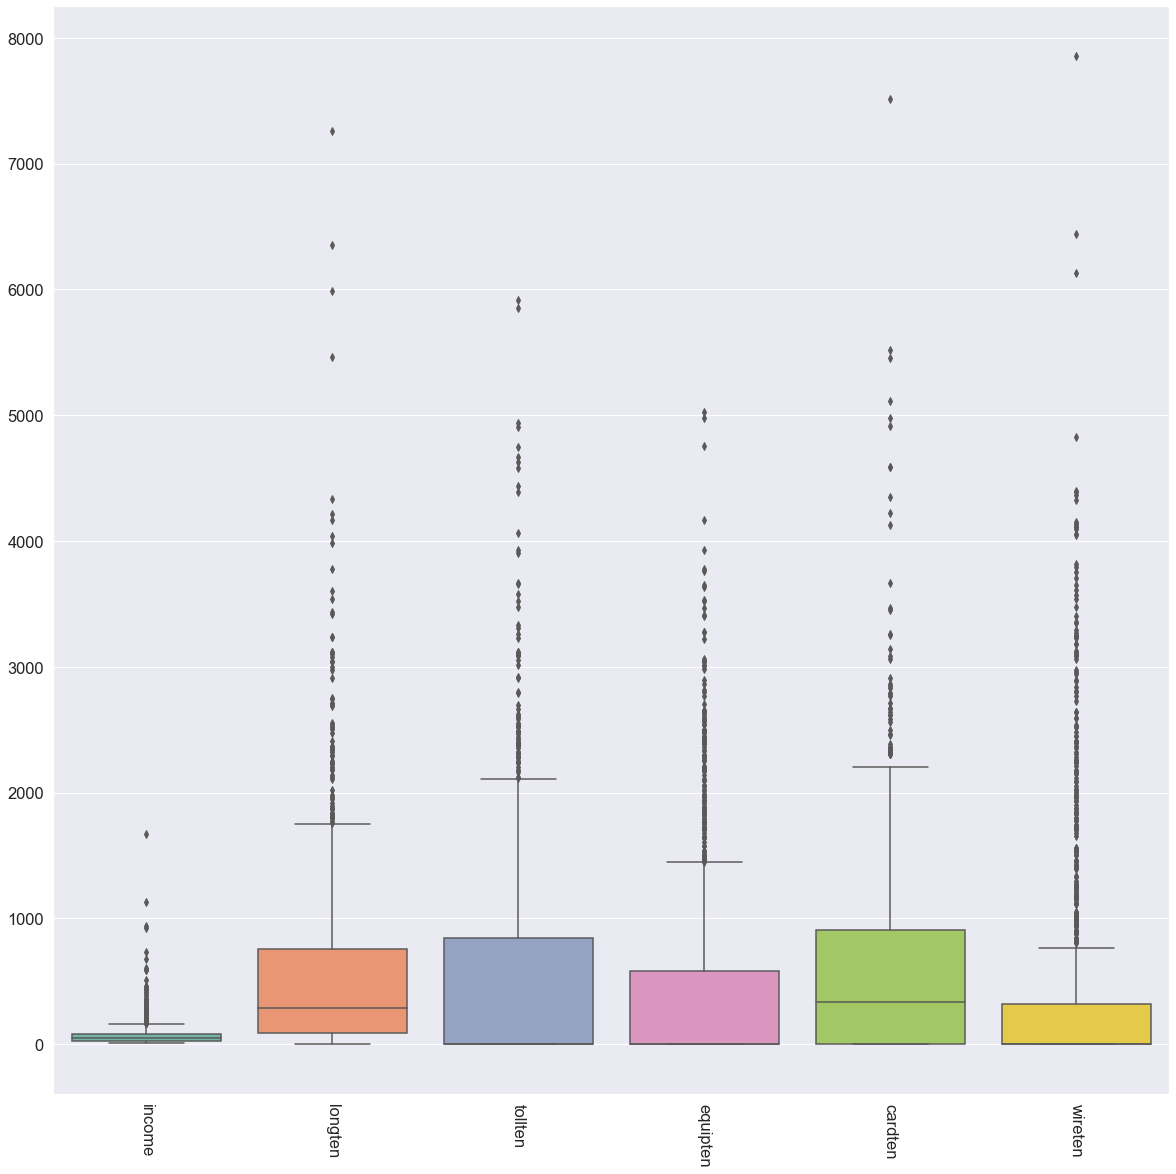

In [ ]:
big_columns = ['income', 'longten', 'tollten', 'equipten', 'cardten', 'wireten']
small_columns = ['tenure', 'age', 'address', 'employ', 'longmon', 'tollmon', 'equipmon', 'cardmon', 'wiremon']

fig = sns.boxplot(data=telco_df[big_columns], palette="Set2")
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90)

[Text(0, 0, 'tenure'),
 Text(0, 0, 'age'),
 Text(0, 0, 'address'),
 Text(0, 0, 'employ'),
 Text(0, 0, 'longmon'),
 Text(0, 0, 'tollmon'),
 Text(0, 0, 'equipmon'),
 Text(0, 0, 'cardmon'),
 Text(0, 0, 'wiremon')]

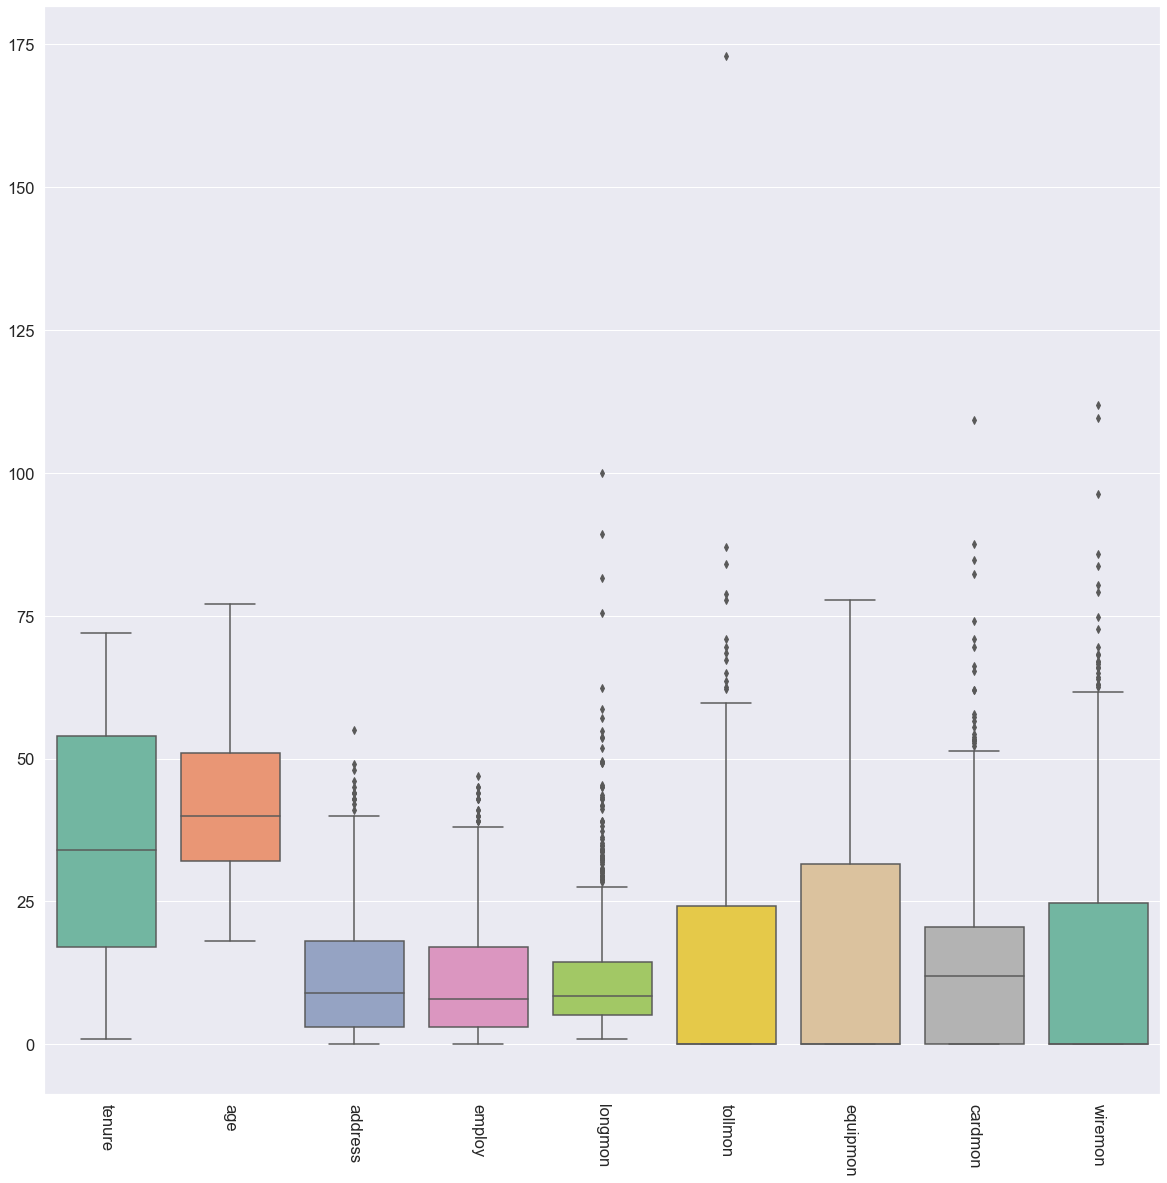

In [ ]:
fig = sns.boxplot(data=telco_df[small_columns], palette="Set2")
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90)

**In those columns where we saw heavy outliers I will take the top 5% of the values and lower them to 95% quantile.**

In [ ]:
cols_with_outliers = ['cardten', 'cardmon', 'longmon', 'longten', 'tollmon', 'tollten', 'wireten', 'wiremon']


for col in cols_with_outliers:
    q95 = telco_df[col].quantile(.95)
    telco_df[col] = telco_df[col].apply(lambda val: min(val,q95))

[Text(0, 0, 'income'),
 Text(0, 0, 'longten'),
 Text(0, 0, 'tollten'),
 Text(0, 0, 'equipten'),
 Text(0, 0, 'cardten'),
 Text(0, 0, 'wireten')]

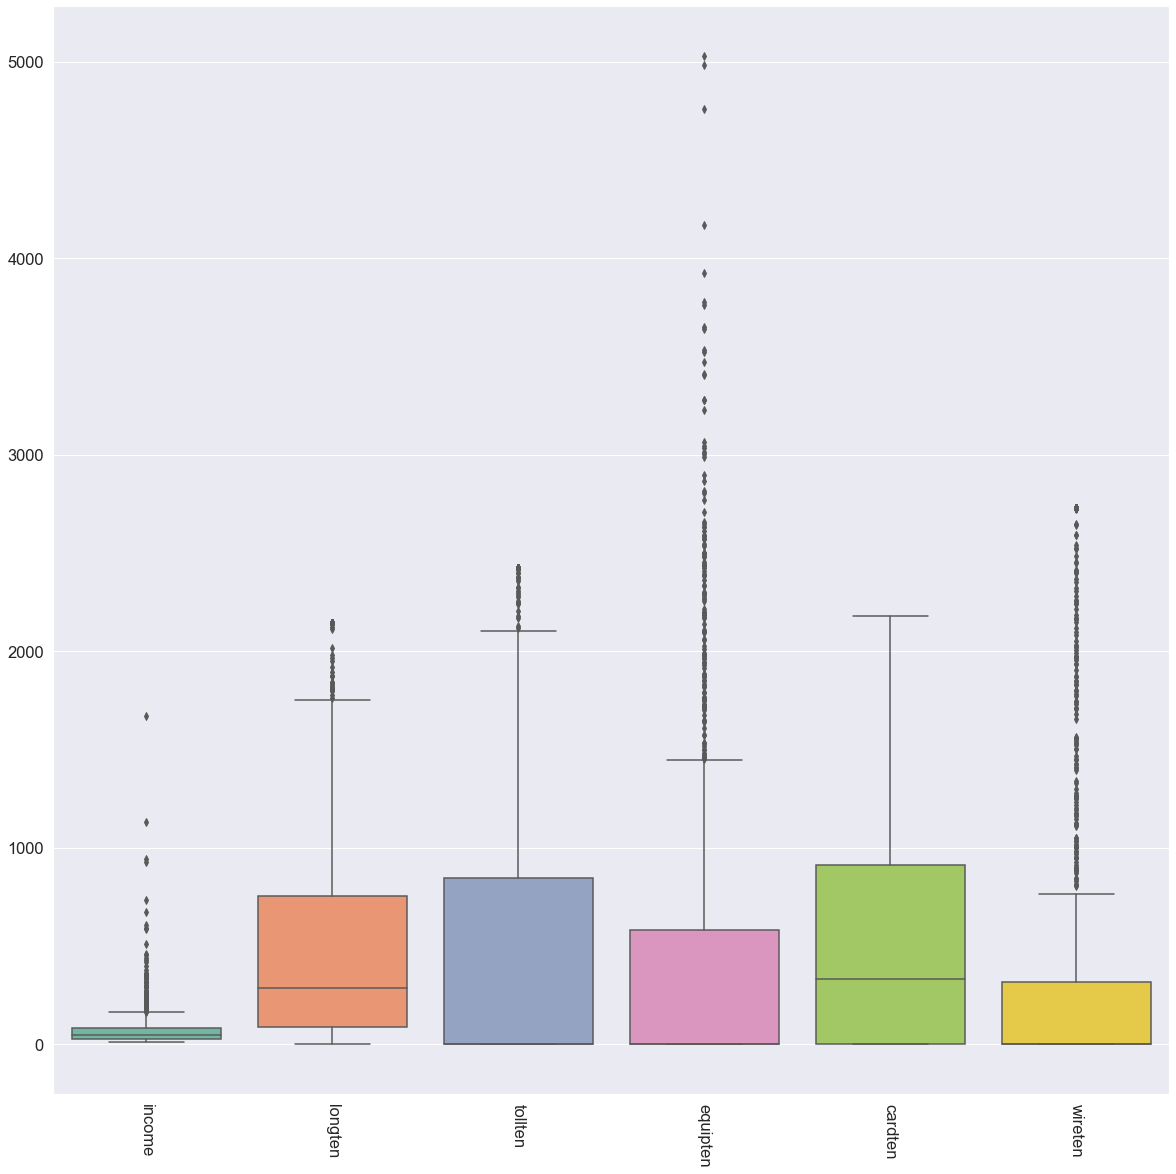

In [ ]:
fig = sns.boxplot(data=telco_df[big_columns], palette="Set2")
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90)

[Text(0, 0, 'tenure'),
 Text(0, 0, 'age'),
 Text(0, 0, 'address'),
 Text(0, 0, 'employ'),
 Text(0, 0, 'longmon'),
 Text(0, 0, 'tollmon'),
 Text(0, 0, 'equipmon'),
 Text(0, 0, 'cardmon'),
 Text(0, 0, 'wiremon')]

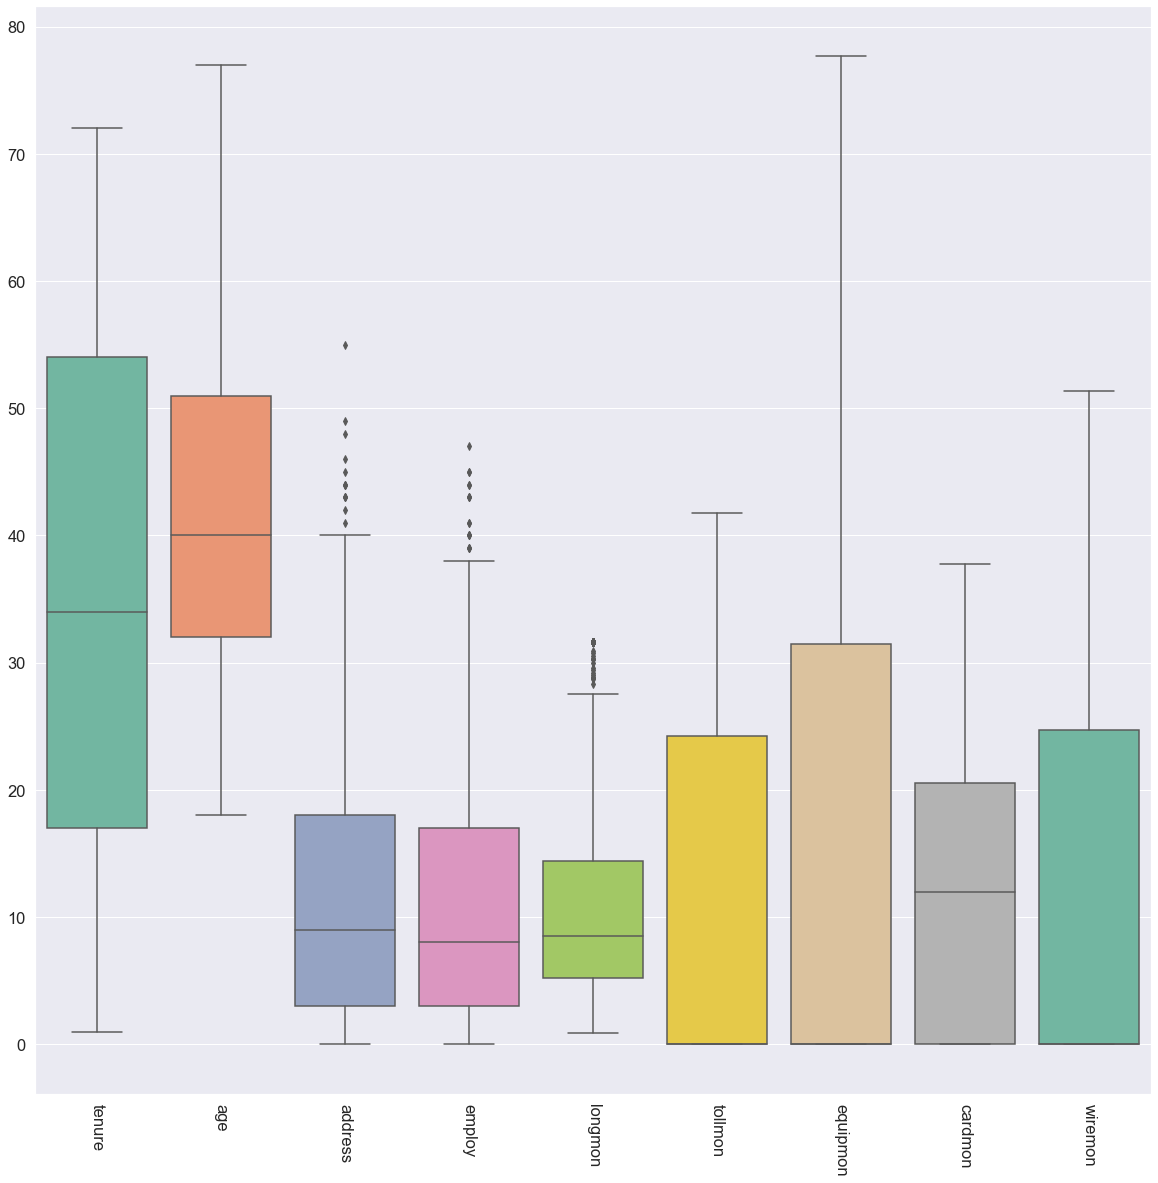

In [ ]:
fig = sns.boxplot(data=telco_df[small_columns], palette="Set2")
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90)

**These boxplots do indeed seem a lot friendlier after this small adjustment to the heavy outliers.**

## Normalization

**A lot of the algorithms require normalization to give the best possible results. Without normalization KNN for example could give more weight to features with higher magnitude of values when calculating distances regardless of the correlation with the target variable.**

In [ ]:
telco_df.describe()

,tenure,age,marital,address,income,ed,employ,retire,gender,reside,tollfree,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,equipten,cardten,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,custcat,churn,is_employed,has_equipment,has_card,has_wireless,region_1,region_2,region_3
count,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000
mean,35.5260,41.6840,0.4950,11.5510,77.5350,2.6710,10.9870,0.0470,0.5170,2.3310,0.4740,0.3860,0.6780,0.2960,11.0678,12.5307,14.2198,13.0336,10.8975,523.4094,504.0797,465.6329,554.7038,394.2689,0.4750,0.3040,0.2610,0.3680,0.4810,0.4850,0.4930,0.5020,0.3710,2.4870,0.2740,0.8940,0.3860,0.6780,0.2960,0.3220,0.3340,0.3440
std,21.3598,12.5588,0.5002,10.0867,107.0442,1.2224,10.0821,0.2117,0.5000,1.4358,0.4996,0.4871,0.4675,0.4567,7.8221,14.5416,19.0685,11.8176,17.7693,591.5537,757.6784,857.2731,641.4524,791.9173,0.4996,0.4602,0.4394,0.4825,0.4999,0.5000,0.5002,0.5002,0.4833,1.1203,0.4462,0.3080,0.4871,0.4675,0.4567,0.4675,0.4719,0.4753
min,1.0000,18.0000,0.0000,0.0000,9.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,17.0000,32.0000,0.0000,3.0000,29.0000,2.0000,3.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,5.2000,0.0000,0.0000,0.0000,0.0000,90.1375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,34.0000,40.0000,0.0000,9.0000,47.0000,3.0000,8.0000,0.0000,1.0000,2.0000,0.0000,0.0000,1.0000,0.0000,8.5250,0.0000,0.0000,12.0000,0.0000,285.4750,0.0000,0.0000,332.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,3.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
75%,54.0000,51.0000,1.0000,18.0000,83.0000,4.0000,17.0000,0.0000,1.0000,3.0000,1.0000,1.0000,1.0000,1.0000,14.4125,24.2500,31.4750,20.5000,24.7125,755.0250,846.9000,579.4500,910.0000,316.5000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
max,72.0000,77.0000,1.0000,55.0000,1668.0000,5.0000,47.0000,1.0000,1.0000,8.0000,1.0000,1.0000,1.0000,1.0000,31.6150,41.7750,77.7000,37.7875,51.3525,2144.7925,2424.2725,5028.6500,2181.0000,2727.5525,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
cols_to_be_normalized = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'reside', 'longmon', 'tollmon', 'equipmon',\
                        'cardmon', 'wiremon', 'longten', 'tollten', 'equipten', 'cardten', 'wireten', 'custcat']


for col in cols_to_be_normalized:
    telco_df[col] = telco_df[col].apply(lambda x: (x - telco_df[col].min()) /
                (telco_df[col].max() - telco_df[col].min()) )

In [ ]:
telco_df.describe()

,tenure,age,marital,address,income,ed,employ,retire,gender,reside,tollfree,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,equipten,cardten,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,custcat,churn,is_employed,has_equipment,has_card,has_wireless,region_1,region_2,region_3
count,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000
mean,0.4863,0.4014,0.4950,0.2100,0.0413,0.4178,0.2338,0.0470,0.5170,0.1901,0.4740,0.3860,0.6780,0.2960,0.3310,0.3000,0.1830,0.3449,0.2122,0.2437,0.2079,0.0926,0.2543,0.1446,0.4750,0.3040,0.2610,0.3680,0.4810,0.4850,0.4930,0.5020,0.3710,0.4957,0.2740,0.8940,0.3860,0.6780,0.2960,0.3220,0.3340,0.3440
std,0.3008,0.2129,0.5002,0.1834,0.0645,0.3056,0.2145,0.2117,0.5000,0.2051,0.4996,0.4871,0.4675,0.4567,0.2547,0.3481,0.2454,0.3127,0.3460,0.2759,0.3125,0.1705,0.2941,0.2903,0.4996,0.4602,0.4394,0.4825,0.4999,0.5000,0.5002,0.5002,0.4833,0.3734,0.4462,0.3080,0.4871,0.4675,0.4567,0.4675,0.4719,0.4753
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.2254,0.2373,0.0000,0.0545,0.0121,0.2500,0.0638,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1400,0.0000,0.0000,0.0000,0.0000,0.0416,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.4648,0.3729,0.0000,0.1636,0.0229,0.5000,0.1702,0.0000,1.0000,0.1429,0.0000,0.0000,1.0000,0.0000,0.2483,0.0000,0.0000,0.3176,0.0000,0.1327,0.0000,0.0000,0.1525,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.6667,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
75%,0.7465,0.5593,1.0000,0.3273,0.0446,0.7500,0.3617,0.0000,1.0000,0.2857,1.0000,1.0000,1.0000,1.0000,0.4399,0.5805,0.4051,0.5425,0.4812,0.3518,0.3493,0.1152,0.4172,0.1160,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.6667,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


**Let's see the correlation values now that the we are done with data massaging**

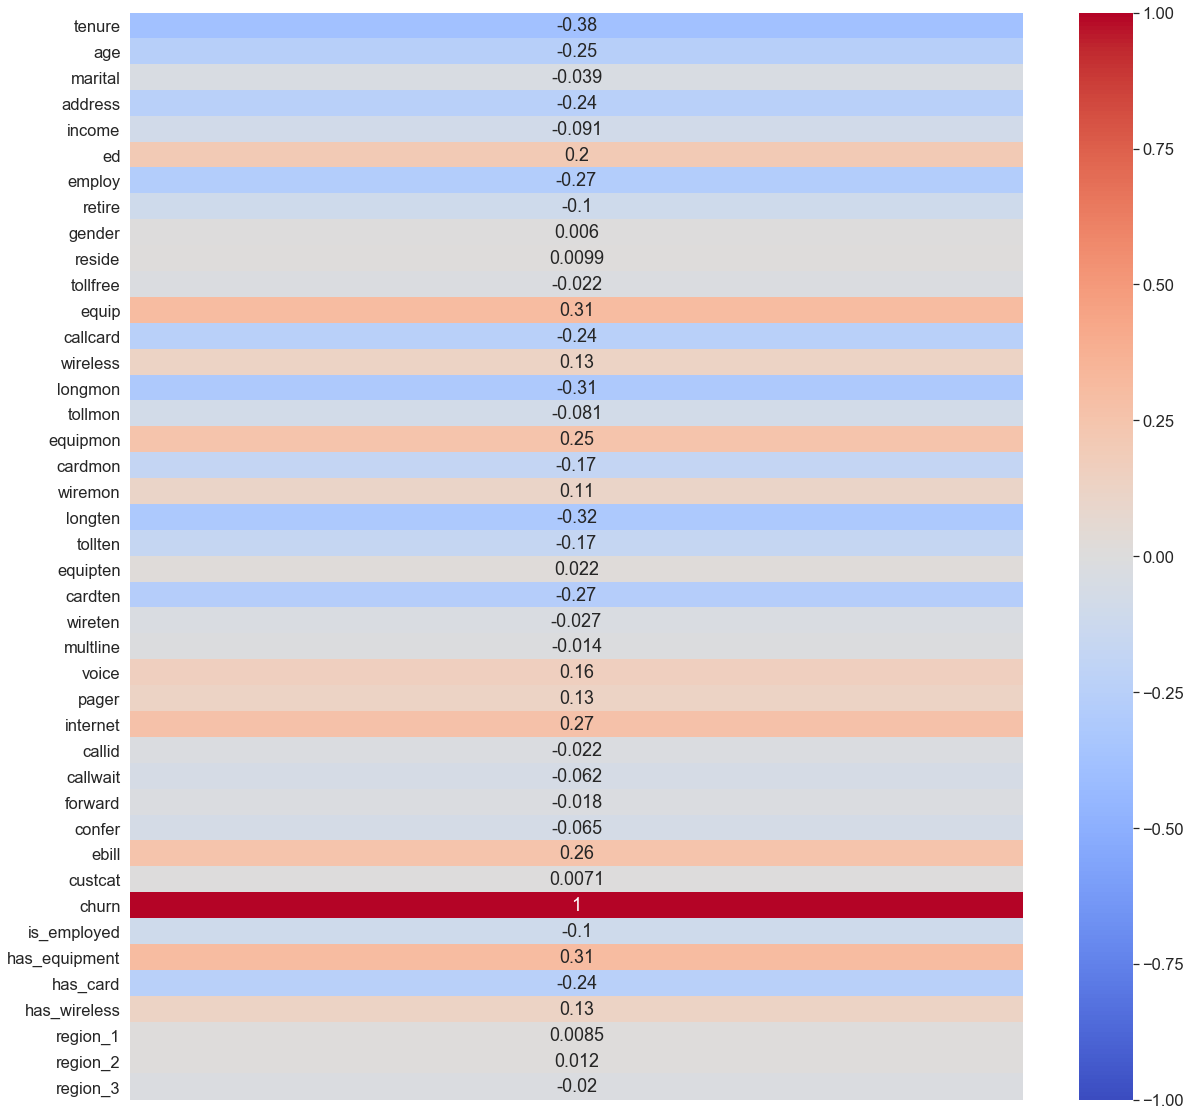

In [ ]:
correlations_with_target = telco_df.corr()['churn'].values.reshape((-1,1))
column_names = telco_df.columns

sns.heatmap(correlations_with_target, annot=True, cmap='coolwarm', vmin=-1, yticklabels = column_names, xticklabels='')

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import sklearn
sklearn.__version__

'0.23.2'

**For modeling I will try different models with parameter optimization. I will try 3 things to compensate for the class imbalance:**

1. The scoring metric used will be F1 macro average, this will optimize for a good balance between precision and recall for both classes.
2. Will try to rebalance the dataset using Synthetic Minority Oversampling Technique (SMOTE).
3. Some algorithms can weight the samples to counteract class imbalances, will try this as well.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from tqdm import tqdm

In [ ]:
X = telco_df.drop('churn', axis=1)
y = telco_df['churn']


def param_optimization(model_class, params, k_range, k_selector=chi2, balancing=None, scoring='f1_macro'):
    best_score = -1
    best_params = None

    for k in tqdm(k_range):
        filter_kbest = SelectKBest(k_selector, k=k)
        X_new = filter_kbest.fit_transform(telco_df.drop('churn', axis=1), telco_df['churn'])

        k_best_cols = telco_df.drop('churn', axis=1).columns[filter_kbest.get_support()]
        X_train, X_valid, y_train, y_valid \
        = train_test_split(telco_df[k_best_cols], telco_df['churn'], test_size = 0.2, random_state = 42)

        if balancing == 'SMOTE':
            over = SMOTE(sampling_strategy=.5)
            under = RandomUnderSampler(sampling_strategy=0.4)
            pipeline = Pipeline(steps=[('under', under), ('over', over)])
            X_train, y_train = over.fit_resample(X_train, y_train)

        param_optimizer = GridSearchCV(estimator = model_class(), param_grid = params,
                                       verbose=0, n_jobs = 4, scoring=scoring)
        param_optimizer.fit(X_train, y_train)


        model = model_class(**param_optimizer.best_params_)

        if balancing == 'WEIGHTED':
            sample_weights = [1 / (y_train.value_counts()[label] / len(y_train)) for label in y_train]
            model.fit(X_train, y_train, sample_weight = sample_weights)
        else:
            model.fit(X_train, y_train)

        predictions = model.predict(X_valid)

        f1_macro_score = f1_score(y_valid, predictions, average='macro')
        if f1_macro_score > best_score:
            best_params = {'k': k, 'k_best_cols': k_best_cols}
            best_params['model_params'] = param_optimizer.best_params_
            best_score = f1_macro_score
            print(f'New Best score found! score: {best_score}, params: {best_params}')

    print(f'FINISHED OPTIMIZATION! score: {best_score}, params: {best_params}')
    return best_params

In [ ]:
best_params = param_optimization(KNeighborsClassifier, { 'n_neighbors': range(1, 2 * len(X.columns)), 'p':[1,2]},\
                                 range(10,25), balancing = 'SMOTE')


X_train, X_valid, y_train, y_valid \
    = train_test_split(telco_df[best_params['k_best_cols']], telco_df['churn'], test_size = 0.2, random_state = 42)

model_knn = KNeighborsClassifier(**best_params['model_params'])
model_knn.fit(X_train, y_train)

predictions = model_knn.predict(X_valid)

print(classification_report(y_valid,predictions))
print(accuracy_score(y_valid, predictions))
print(balanced_accuracy_score(y_valid, predictions))

  0%|                                                                                                                   | 0/15 [00:00<?, ?it/s]

New Best score found! score: 0.680174202987309, params: {'k': 10, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'equipmon', 'longten', 'cardten',
       'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'n_neighbors': 9, 'p': 1}}


  7%|███████▏                                                                                                   | 1/15 [00:09<02:12,  9.49s/it]

New Best score found! score: 0.7073934197543466, params: {'k': 11, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'longmon', 'equipmon', 'longten',
       'cardten', 'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'n_neighbors': 9, 'p': 1}}


 47%|█████████████████████████████████████████████████▉                                                         | 7/15 [00:41<00:48,  6.01s/it]

New Best score found! score: 0.7271309771309771, params: {'k': 17, 'k_best_cols': Index(['tenure', 'employ', 'equip', 'callcard', 'wireless', 'longmon',
       'equipmon', 'longten', 'tollten', 'cardten', 'voice', 'pager',
       'internet', 'ebill', 'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'n_neighbors': 7, 'p': 2}}


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 13/15 [01:13<00:10,  5.34s/it]

New Best score found! score: 0.7333333333333334, params: {'k': 23, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'wiremon',
       'longten', 'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'n_neighbors': 47, 'p': 1}}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:24<00:00,  5.36s/it]


FINISHED OPTIMIZATION! score: 0.7333333333333334, params: {'k': 23, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'wiremon',
       'longten', 'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'n_neighbors': 47, 'p': 1}}
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       149
           1       0.66      0.57      0.61        51

    accuracy                           0.81       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.81      0.81      0.81       200

0.815
0.7339781550203974


In [ ]:
best_params = param_optimization(KNeighborsClassifier, { 'n_neighbors': range(1, 2 * len(X.columns)), 'p':[1,2]}, range(10,25))


X_train, X_valid, y_train, y_valid \
    = train_test_split(telco_df[best_params['k_best_cols']], telco_df['churn'], test_size = 0.2, random_state = 42)

model_knn = KNeighborsClassifier(**best_params['model_params'])
model_knn.fit(X_train, y_train)

predictions = model_knn.predict(X_valid)

print(classification_report(y_valid,predictions))
print(accuracy_score(y_valid, predictions))
print(balanced_accuracy_score(y_valid, predictions))

  0%|                                                                                                                   | 0/15 [00:00<?, ?it/s]

New Best score found! score: 0.7132616487455197, params: {'k': 10, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'equipmon', 'longten', 'cardten',
       'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'n_neighbors': 51, 'p': 1}}


  7%|███████▏                                                                                                   | 1/15 [00:04<00:56,  4.02s/it]

New Best score found! score: 0.7282508905291762, params: {'k': 11, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'longmon', 'equipmon', 'longten',
       'cardten', 'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'n_neighbors': 38, 'p': 2}}


 20%|█████████████████████▍                                                                                     | 3/15 [00:12<00:49,  4.10s/it]

New Best score found! score: 0.7368327465414843, params: {'k': 13, 'k_best_cols': Index(['tenure', 'employ', 'equip', 'callcard', 'longmon', 'equipmon',
       'longten', 'cardten', 'voice', 'internet', 'ebill', 'has_equipment',
       'has_card'],
      dtype='object'), 'model_params': {'n_neighbors': 43, 'p': 1}}


 47%|█████████████████████████████████████████████████▉                                                         | 7/15 [00:29<00:34,  4.30s/it]

New Best score found! score: 0.7408146824979861, params: {'k': 17, 'k_best_cols': Index(['tenure', 'employ', 'equip', 'callcard', 'wireless', 'longmon',
       'equipmon', 'longten', 'tollten', 'cardten', 'voice', 'pager',
       'internet', 'ebill', 'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'n_neighbors': 37, 'p': 2}}


 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 12/15 [00:53<00:14,  4.73s/it]

New Best score found! score: 0.7446074201898187, params: {'k': 22, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'n_neighbors': 43, 'p': 1}}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.97s/it]


FINISHED OPTIMIZATION! score: 0.7446074201898187, params: {'k': 22, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'n_neighbors': 43, 'p': 1}}
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       149
           1       0.66      0.57      0.61        51

    accuracy                           0.81       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.81      0.81      0.81       200

0.815
0.7339781550203974


### KNN

**The KNN algorithm is sensitive to outliers and needs data to be normalized. I did this during the preprocessing so the algorithm can be used.**

**KNN doesn't use weighing of samples so I tried SMOTE. Unfortunately the rebalancing was not successful, maybe because of the low sample size the algorithm can't create good new samples for the churn samples, and throwing away non-churn samples is very costly regarding information.**

**Best KNN model statistics> F1 macro average: 0.74, Balanced Accuracy: 0.73**

**Best hyperparameters:**

- Columns:
```python
['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless']```
- N Neighbours: 43
- Distance metric: Manhattan

In [ ]:
best_params = param_optimization(RandomForestClassifier, { 'n_estimators': range(1,50,2), 'max_depth': range(1,35,2)}\
                                 ,range(10,25), balancing = 'WEIGHTED')


X_train, X_valid, y_train, y_valid \
    = train_test_split(telco_df[best_params['k_best_cols']], telco_df['churn'], test_size = 0.2, random_state = 42)

model_rf = RandomForestClassifier(**best_params['model_params'])

sample_weights = [1 / (y_train.value_counts()[label] / len(y_train)) for label in y_train]
model_rf.fit(X_train, y_train, sample_weight = sample_weights)

predictions = model_rf.predict(X_valid)


print(classification_report(y_valid,predictions))
print(accuracy_score(y_valid, predictions))
print(balanced_accuracy_score(y_valid, predictions))

  0%|                                                                                                                   | 0/15 [00:00<?, ?it/s]

New Best score found! score: 0.6836158192090396, params: {'k': 10, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'equipmon', 'longten', 'cardten',
       'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'max_depth': 7, 'n_estimators': 27}}


  7%|███████▏                                                                                                   | 1/15 [00:36<08:27, 36.26s/it]

New Best score found! score: 0.7328800388538126, params: {'k': 11, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'longmon', 'equipmon', 'longten',
       'cardten', 'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'max_depth': 5, 'n_estimators': 45}}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:22<00:00, 38.15s/it]


FINISHED OPTIMIZATION! score: 0.7328800388538126, params: {'k': 11, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'longmon', 'equipmon', 'longten',
       'cardten', 'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'max_depth': 5, 'n_estimators': 45}}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       149
           1       0.52      0.65      0.58        51

    accuracy                           0.76       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.78      0.76      0.77       200

0.76
0.7228582708251086


In [ ]:
best_params = param_optimization(RandomForestClassifier, { 'n_estimators': range(1,50,2), 'max_depth': range(1,35,2)},\
                                range(10,25))


X_train, X_valid, y_train, y_valid \
    = train_test_split(telco_df[best_params['k_best_cols']], telco_df['churn'], test_size = 0.2, random_state = 42)

model_rf = RandomForestClassifier(**best_params['model_params'])
model_rf.fit(X_train, y_train)

predictions = model_rf.predict(X_valid)


print(classification_report(y_valid,predictions))
print(accuracy_score(y_valid, predictions))


print(balanced_accuracy_score(y_valid, predictions))

  0%|                                                                                                                   | 0/15 [00:00<?, ?it/s]

New Best score found! score: 0.6799317187666702, params: {'k': 10, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'equipmon', 'longten', 'cardten',
       'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'max_depth': 7, 'n_estimators': 35}}


  7%|███████▏                                                                                                   | 1/15 [00:36<08:24, 36.01s/it]

New Best score found! score: 0.7268046653357151, params: {'k': 11, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'longmon', 'equipmon', 'longten',
       'cardten', 'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'max_depth': 3, 'n_estimators': 1}}


 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 12/15 [07:17<01:50, 36.82s/it]

New Best score found! score: 0.7429400315816532, params: {'k': 22, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'max_depth': 7, 'n_estimators': 19}}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:08<00:00, 36.90s/it]


FINISHED OPTIMIZATION! score: 0.7429400315816532, params: {'k': 22, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'max_depth': 7, 'n_estimators': 19}}
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       149
           1       0.68      0.53      0.59        51

    accuracy                           0.81       200
   macro avg       0.76      0.72      0.74       200
weighted avg       0.81      0.81      0.81       200

0.815
0.7210817212791156


### Random Forest Classifier

**Tree based algorithms are very robust. They are almost ignorant to outliers and does not need data to be normalized.**

**Random Forests support weighing of samples and indeed turning it on helped the learning process**

**Best Random Forest model statistics> F1 macro average: 0.74, Balanced Accuracy: 0.72**

**Best hyperparameters:**

- Columns:
```python
['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless']```
- Max Depth: 7
- N Estimators (number of trees): 19

In [ ]:
param_grid = [
    {
        'kernel': ['linear'],
        'C': np.linspace(.5, 6, 7),
        'class_weight': [None, 'balanced']
    },
    {
        'kernel': ['poly'],
        'C': np.linspace(.5, 6, 7),
        'degree': range(5, 10),
        'class_weight': [None, 'balanced']
    },
    {
        'kernel': ['rbf'],
        'C': np.linspace(.5, 6, 7),
        'gamma': np.linspace(0.001, 2, 10),
        'class_weight': [None, 'balanced']
    }
]

best_params = param_optimization(SVC, param_grid, [10, 13, 15, 17, 22, 25])


X_train, X_valid, y_train, y_valid \
    = train_test_split(telco_df[best_params['k_best_cols']], telco_df['churn'], test_size = 0.2, random_state = 42)

model_svc = SVC(**best_params['model_params'])
model_svc.fit(X_train, y_train)

predictions = model_svc.predict(X_valid)


print(classification_report(y_valid,predictions))
print(accuracy_score(y_valid, predictions))
print(balanced_accuracy_score(y_valid, predictions))


  0%|                                                                                                                    | 0/6 [00:00<?, ?it/s]

New Best score found! score: 0.7040258524357464, params: {'k': 10, 'k_best_cols': Index(['tenure', 'equip', 'callcard', 'equipmon', 'longten', 'cardten',
       'internet', 'ebill', 'has_equipment', 'has_card'],
      dtype='object'), 'model_params': {'C': 1.1111111111111112, 'class_weight': 'balanced', 'gamma': 0.22311111111111112, 'kernel': 'rbf'}}



 67%|████████████████████████████████████████████████████████████████████████                                    | 4/6 [03:44<02:13, 66.70s/it]

New Best score found! score: 0.7132616487455197, params: {'k': 22, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'C': 6.0, 'class_weight': None, 'gamma': 0.22311111111111112, 'kernel': 'rbf'}}



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:17<00:00, 41.23s/it]

FINISHED OPTIMIZATION! score: 0.7132616487455197, params: {'k': 22, 'k_best_cols': Index(['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless'],
      dtype='object'), 'model_params': {'C': 6.0, 'class_weight': None, 'gamma': 0.22311111111111112, 'kernel': 'rbf'}}
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       149
           1       0.64      0.49      0.56        51

    accuracy                           0.80       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.79      0.80      0.79       200

0.8
0.6981181734438742


### Support Vector Machines

**Support vector based models are also reliant on distance calculations thus sensitive to outliers and normalization.**

**SVC also supports weighing of samples but it doesn't seem to make a significant difference. The best classifier seems to be the rbf version.**

**Best SVC model statistics> F1 macro average: 0.71, Balanced Accuracy: 0.69**

**Best hyperparameters:**

- Columns:
```python
['tenure', 'age', 'address', 'ed', 'employ', 'retire', 'equip',
       'callcard', 'wireless', 'longmon', 'equipmon', 'cardmon', 'longten',
       'tollten', 'cardten', 'voice', 'pager', 'internet', 'ebill',
       'has_equipment', 'has_card', 'has_wireless']```
- kernel: rbf
- C: 6
- gamma: 0.22


Note: On my machine SVC hyperparameter optimization failed multiple times and had to be restarted, in case I had access to a stronger machine I am sure this would yield the best results.

# Summary

**The given model contained very few samples for reliable churn prediction, thus I had to be very gentle with outliers.**

**The dataset is imbalanced and I could hardly create good synthetic data due to the low sample count.**

**The dataset contained a few columns where I could extract additional information by feature engineering. The engineered *has_card*, *has_equipment* and *has_wireless* columns are among the best K features selected.**

**I would advise adding 2 additional columns to the data:**
- **competition_investment: Has there been any infrastructural investments made by the competition in the past 6 months**
- **complaints: Has the subscriber called the service desk due to outages or any other complaints regarding the service in the past 3 months? This could even be a numeric field containing the number of calls, or the last call date.**

**The best model I created was KNN with a balanced accuracy of 73%. Below we can see the confusion matrix of it on the validation set.**

**In the future I would definetily try building a neural network model for the data. Also I would try a more extensive hyperparameter tuning on a stronger machine, along with a PCA dimensionality reduction.**


Text(0.5, 56.5, 'Predicted')

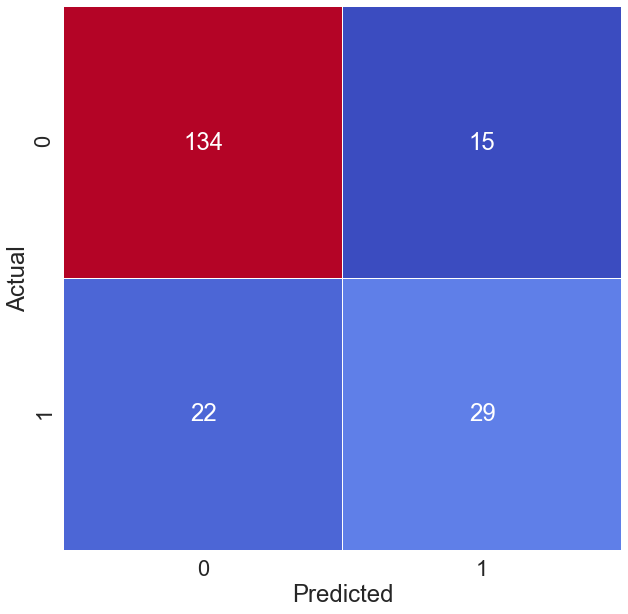

In [ ]:
X_train, X_valid, y_train, y_valid \
    = train_test_split(telco_df[best_params['k_best_cols']], telco_df['churn'], test_size = 0.2, random_state = 42)

model_knn.fit(X_train, y_train)

predictions = model_knn.predict(X_valid)

conf_matrix = confusion_matrix(y_valid, predictions)


sns.set(font_scale=2)
figsize(10, 10)

fig = sns.heatmap(conf_matrix, annot=True, linewidths=.5, cmap='coolwarm', cbar=False, fmt='d')
fig.set_ylabel('Actual')
fig.set_xlabel('Predicted')